# Animal Shelter (Random Forest)


In [387]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the Animal Shelter dataset and display a sample.

In [388]:
df = pd.read_csv("train.csv")

In [389]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [390]:
df.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


Also load the intake dataset downloaded from https://data.austintexas.gov/Health-and-Community-Services/Austin-Animal-Center-Intakes/wter-evkm so as to augment the kaggle dataset with further information about the animals.

# 1. Data Preparation


Split the "SexuponOutcome" field into "Sex" and "Neutered".

In [391]:
def splitSex(df):
    df.loc[df["SexuponOutcome"].isnull(), "SexuponOutcome"]="unknown"

    df["Sex"] = df["SexuponOutcome"].str.lower().str.contains(" male")
    df.loc[df["SexuponOutcome"].str.lower().str.contains(" male"), "Sex"] = "male"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("female"), "Sex"] = "female"
    df.loc[df["SexuponOutcome"].str.lower().str.contains("unknown"), "Sex"] = "unknown"

    df["Neutered"] = (df["SexuponOutcome"].str.lower().str.contains("neutered")) |  (df["SexuponOutcome"].str.lower().str.contains("spayed"))
    df["Neutered"] = df["Neutered"].astype(int)
    df[["SexuponOutcome", "Sex", "Neutered"]].head()
    
splitSex(df)

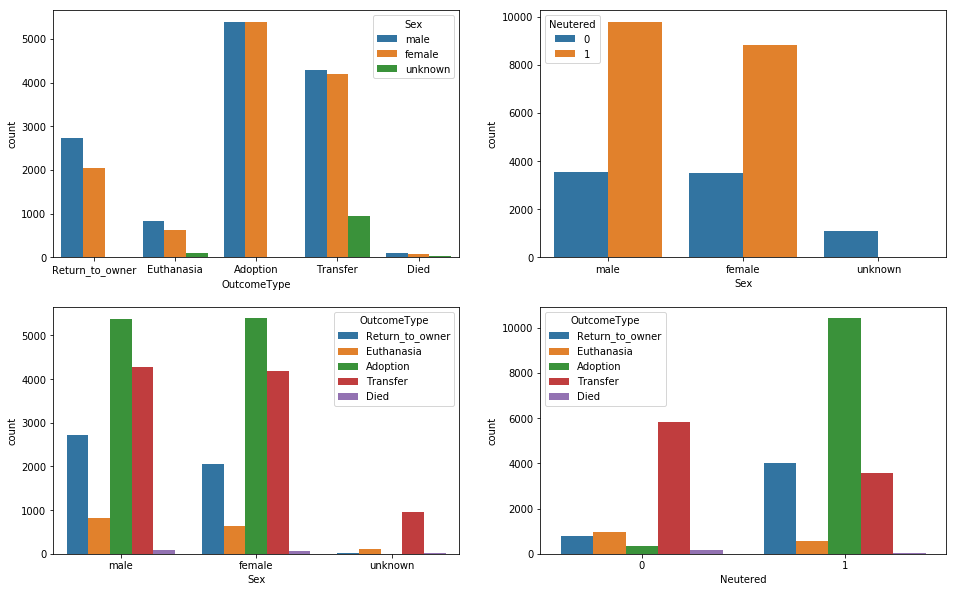

In [392]:
f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2, 2, figsize=(16, 10))
sns.countplot(data=df, x='OutcomeType',hue='Sex', ax=ax1)
sns.countplot(data=df, x='Sex',hue='OutcomeType', ax=ax2)
sns.countplot(data=df, x="Sex", hue="Neutered", ax=ax3)
sns.countplot(data=df, x="Neutered", hue="OutcomeType", ax=ax4)

Clean up breed

In [393]:
def cleanupBreed(df):
    df["PureBreed"] = ~df["Breed"].str.lower().str.contains("mix")
    df.loc[df["Breed"].str.contains("/"), "PureBreed"]=False
    df["PureBreed"] = df["PureBreed"].astype(int)
    df[["Breed", "PureBreed"]].head(10)
    
cleanupBreed(df)

Plot normalized ratios of outcomes by breed purity. Purebreed dogs are more likely to be returned to owner (not surprising), however not more likely to be adopted(surprising).

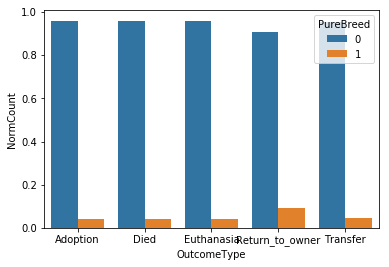

In [394]:
def normalizeCounts(df, x, sub_x, norm_over_x=False):

    agg1 = df.pivot_table(index=[x, sub_x], values=["AnimalID"], aggfunc=len)

    agg1.columns=["NormCount"]
    agg1["NormCount"] = agg1["NormCount"].astype(float)
    agg2 = df.pivot_table(index=[sub_x], values="AnimalID", aggfunc=len)
    #print agg2
    
    x_vals = agg1.index.levels[0].values
    
    #print agg1
    for x_val in x_vals:
        sub_x_vals = agg1.loc[x_val].index.unique().values
        if norm_over_x:
            tot = sum(agg1.loc[x_val, "NormCount"].values)
        
            
        for sub_x_val in sub_x_vals:
            if not norm_over_x:
                tot = agg2.loc[sub_x_val][0]
        
            val = agg1.loc[x_val].loc[sub_x_val,"NormCount"]
            val /= tot
            agg1.loc[x_val].loc[sub_x_val]=val


    agg1 = agg1.reset_index()
    #print agg1
    
    return agg1

sns.barplot(data=normalizeCounts(df, "OutcomeType", "PureBreed", norm_over_x=True), x="OutcomeType", hue="PureBreed", y="NormCount")
#sns.countplot(data=df, x="OutcomeType", hue="PureBreed")

The dog breed potentially encodes information that could improve classifier predictions, such as size of dog, breed popularity, breed temperament and longevity etc. This information, however is difficult to extract from the breed. Instead we encode the breed field into a set of features that can then be used by the classifier. The breed field is transformed into features by calculating a term-document matrix taking the rows in the Breed column as the document corpus. This results in the breed words being vectorized. 

This should allow the classifier to implicitly infer information regarding the breeds which affects the outcome. For example if chihuahuas or chihuahua mixes are unpopular for adoption, any breed mentioning chihuahua should result in a lower probability of adoption in the classifier. If medium sized breeds tend to be adopted more frequently, this should also be a correlation that emerges in the classifier. 

In [395]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.decomposition import PCA

def preprocessBreed(df):
    #vec = CountVectorizer()
    vec = TfidfVectorizer()
    
    breedsTDM = vec.fit_transform(df["Breed"].str.replace("Mix", "").str.replace("/", " ").str.lower())
    print breedsTDM.shape
    
    return breedsTDM
    
def processBreed(df, breedsTDM):
    breedsdf = pd.DataFrame(breedsTDM.toarray())
    breedCols = ["Breed_"+str(i) for i in range(0, breedsTDM.shape[1]) ]
    breedsdf.columns = breedCols
    #print breedsdf.head()

    df = df.join(breedsdf)
    #print df.head()
    return df

breedsTDM = preprocessBreed(df)
df = processBreed(df, breedsTDM)
df.head()

(26729, 261)


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_251,Breed_252,Breed_253,Breed_254,Breed_255,Breed_256,Breed_257,Breed_258,Breed_259,Breed_260
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We define a function that translates the age fields in the dataset to days by parsing the units (year(s), month(s), week(s)). We then map the age in days to an ageBracket field so as to categories the animals as (BABY, JUVENILE, ADULT, SENIOR). Animal shelters do not allow animals to be adopted before they are weaned, therefore the "BABY" bracket should add resultion to our classifier.

In [396]:
def getAgeInDays(ageStr):
    if pd.isnull(ageStr):
        return ageStr
    
    ageParts = ageStr.lower().split(" ")
    val = int(ageParts[0])
    units = ageParts[1]
    
    if units[-1:]=="s":
        units = units[0:-1]
    
    if units=="year":
        val = 365*val
    elif units=="month":
        val = 30*val
    elif units=="week":
        val = 7*val
    
    return val

def getAgeBracket(ageInDays):
    if ageInDays<=42:
        return "baby"
    elif ageInDays<=365:
        return "juvenile"
    elif ageInDays<=365*9:
        return "adult"
    else:
        return "senior"

    
def processAge(df):
    df["AgeDays"] = df["AgeuponOutcome"].apply(getAgeInDays)
    meanAge = df[["AgeDays"]].mean()

    df.loc[df["AgeDays"].isnull(), "AgeDays"]=meanAge[0]
    df["AgeBracket"] = df["AgeDays"].apply(getAgeBracket)
    
    
processAge(df)


A quick histogram of age distribution shows that most animals at the shelter are younger than about 2 years of age.

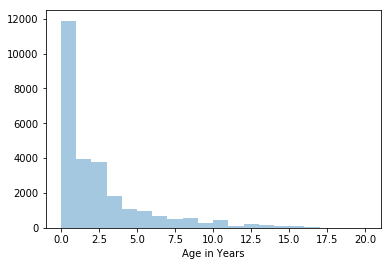

In [397]:

sns.distplot(df.AgeDays/365, bins = 20, kde=False, axlabel="Age in Years")

Visualising outcomes based on these age categories reveals, unsurprisingly, that juveniles are more likely to be adopted (or transferred) than any other age bracket. Babies are less likely to be adopted as shelters usually don't allow them to until they are weaned and are also the most likely to die. Interestingly senior dogs are more likely to be returned to their owner. These facts should have explanatory value in our model.

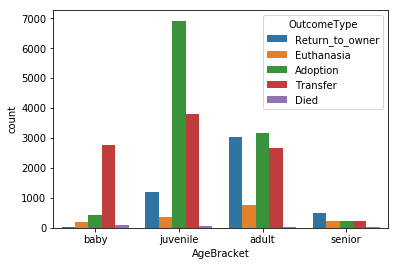

In [398]:


sns.countplot(data=df, x="AgeBracket", hue="OutcomeType", order=["baby", "juvenile", "adult", "senior"])

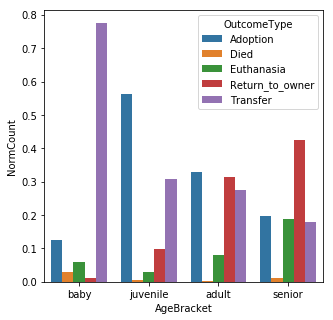

In [399]:
# Generate distribution of dog sizes grouped by outcome, normalized over outcome.
f, ax1 = plt.subplots(1, 1, figsize=(5, 5))
sns.barplot(data=normalizeCounts(df, "AgeBracket", "OutcomeType", norm_over_x=True), x="AgeBracket", hue="OutcomeType", y="NormCount", order=["baby", "juvenile", "adult", "senior"])



Here we also take the DateTime column and we split the day into 3 hour segments. This should tell us the most likely time of day for an outcome. It looks like most adoptions as well as most transfers occur during the afternoon and early evening, peaking around 15:00.

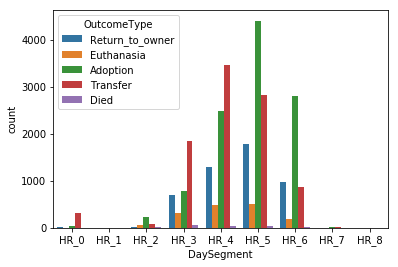

In [400]:
def tsToDaySegment(ts):
    return "HR_"+str(int(ts.hour/3))
    
def processDate(df):
    df["DateTime"] = pd.to_datetime(df["DateTime"])
    df["DaySegment"] = df["DateTime"].apply(tsToDaySegment)
    df["OutcomeDay"] = df["DateTime"].dt.day
    df["OutcomeMonth"] = df["DateTime"].dt.month
    df["OutcomeHour"] = df["DateTime"].dt.hour
    
processDate(df)

sns.countplot(data=df, x="DaySegment", hue="OutcomeType", order=["HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8"])

Does the day of the week make a difference to the outcomes? 

It looks like adoptions are much more likely during the weekend.

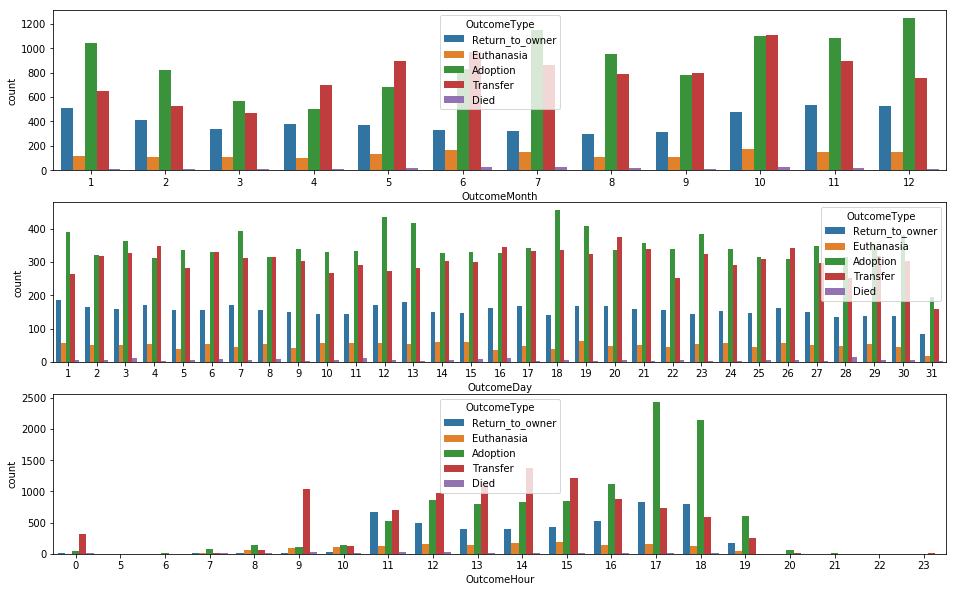

In [401]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10))
sns.countplot(data=df, x="OutcomeMonth", hue="OutcomeType", ax=ax1)
sns.countplot(data=df, x="OutcomeDay", hue="OutcomeType", ax=ax2)
sns.countplot(data=df, x="OutcomeHour", hue="OutcomeType", ax=ax3)
plt.show()

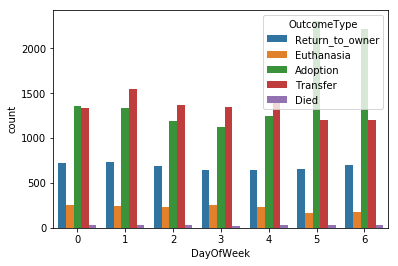

In [402]:
weekdist = pd.DataFrame(data=df[["DateTime", "OutcomeType"]])
weekdist["DayOfWeek"] = weekdist["DateTime"].apply(lambda ts: ts.weekday())

sns.countplot(data=weekdist, x="DayOfWeek", hue="OutcomeType")

In order to capture this information we create a new "IsWeekend" field in our dataset.

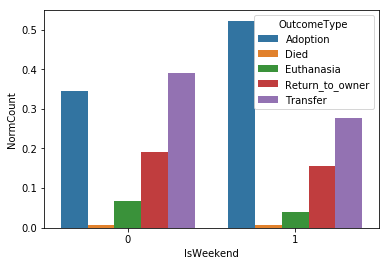

In [403]:
def processWeekend(df):
    df["IsWeekend"] = df["DateTime"].apply(lambda ts: (ts.weekday()>=5))
    df["IsWeekend"] = df["IsWeekend"].astype(int)
#sns.countplot(data=df, x="IsWeekend", hue="OutcomeType")


processWeekend(df)
sns.barplot(data=normalizeCounts(df, "IsWeekend", "OutcomeType", norm_over_x=True), x="IsWeekend", hue="OutcomeType", y="NormCount")

Does having a name make a difference to the outcome? Yes. Having a name is much more likely to result in adoption and/or return to owner.

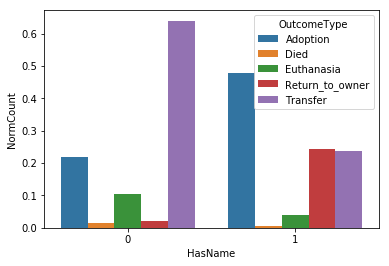

In [404]:
def processName(df):
    df["HasName"] = ~df["Name"].isnull()
    df["HasName"] = df["HasName"].astype(int)


processName(df)

#sns.countplot(data=df, x="HasName", hue="OutcomeType")
sns.barplot(data=normalizeCounts(df, "HasName", "OutcomeType", norm_over_x=True), x="HasName", hue="OutcomeType", y="NormCount")

We also need to simplify the color field. There are too many unique colors. We do this by splitting on "/" or " " and taking only the first word.

In [405]:
df["Color"].unique().size

366

In [406]:
#df["SimpleColor"] = df["Color"].apply(lambda c: c.split("/| ")[0])
def processColor(df):
    df["SimpleColor"] = df["Color"].apply(lambda c: c.lower().split("/")[0].split(" ")[0])


processColor(df)

print df["SimpleColor"].unique().size
df[["Color", "SimpleColor"]].head()


29


,Color,SimpleColor
0,Brown/White,brown
1,Cream Tabby,cream
2,Blue/White,blue
3,Blue Cream,blue
4,Tan,tan


['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']


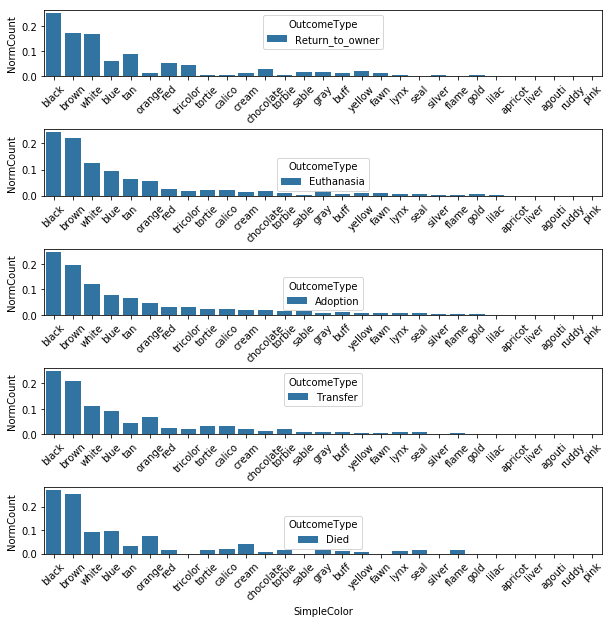

In [407]:
outcomes = df["OutcomeType"].unique()
print outcomes
f, ax1 = plt.subplots(outcomes.size, 1, figsize=(10, 10))

df["SimpleColor"].value_counts().index
for i in range(0,len(outcomes)):
    outcome = outcomes[i]
    ax1[i].tick_params(axis="x", rotation=45)
    sns.barplot(data=normalizeCounts(df.loc[df["OutcomeType"]==outcome,:], x="SimpleColor", sub_x="OutcomeType", norm_over_x=False), x="SimpleColor", hue="OutcomeType", y="NormCount", order=df["SimpleColor"].value_counts().index, ax=ax1[i])
    
f.subplots_adjust(hspace=0.8)

How balanced or unbalanced are our classes?

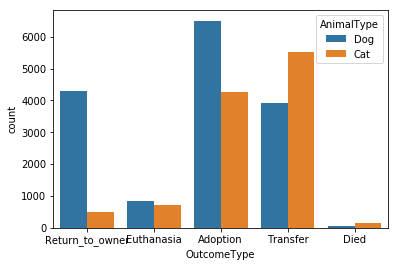

In [408]:
sns.countplot(data=df, x="OutcomeType", hue="AnimalType")

It is clear that there is a severe inbalance in the prediction classes.

The simplest solution is to duplicate records in the minority classes, however experiments with this approach resulted in a worse classifier performance.

Instead we use SMOTE (further down) which empirically gives much better results.

In [409]:
#outcomeCounts = df.pivot_table(index=["OutcomeType"], values=["AnimalID"], aggfunc=len)
#
#maxOutcomeCount = np.max(outcomeCounts.values.ravel())
#
#outcomes = df["OutcomeType"].unique()
#
##newrecords = pd.DataFrame(columns=df.columns)
#
#newrecords = pd.DataFrame.from_items(
#    [(name, pd.Series(data=None, dtype=series.dtype)) for name, series in df.iteritems()])
#
#for outcome in outcomes:
#    outcomeCount = outcomeCounts.loc[outcome].values[0]
#    diff = maxOutcomeCount - outcomeCount
#    
#    if diff > 0:
#        subset = pd.DataFrame(df.loc[df["OutcomeType"]==outcome,:])
#        subset = subset.iloc[np.random.randint(0, subset.index.size, size=diff)]
#        print outcome, ": added ", subset.index.size, " records"
#        newrecords = newrecords.append(subset)
#        
#print "Total records added: ", newrecords.index.size

#df = df.append(newrecords)

#sns.countplot(data=df, x="OutcomeType")

# Machine Learning Model

Prepare the dataset for learning

N.B. We will treat OutcomeType as the dependant variable. OutcomeType is directly inferable from OutcomeSubtype, however this goes contrary to the spirit of the Kaggle challenge and the Kaggle testing set does not include this field among the features, therefore in order for our learning algorithm not to be trivial, we will remove this field.

In [410]:
df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,Breed_260,AgeDays,AgeBracket,DaySegment,OutcomeDay,OutcomeMonth,OutcomeHour,IsWeekend,HasName,SimpleColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,0.0,365.0,juvenile,HR_6,12,2,18,0,1,brown
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,0.0,365.0,juvenile,HR_4,13,10,12,1,1,cream
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,0.0,730.0,adult,HR_4,31,1,12,1,1,blue
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,0.0,21.0,baby,HR_6,11,7,19,0,0,blue
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0.0,730.0,adult,HR_4,15,11,12,0,0,tan


Select only the fields we need for learning.

In [411]:
# Experimentally reduce problem to a binary lives/dies classification
def reduceOutcome(outcome):
    return outcome in ("Adoption", "Return_to_owner", "Transfer")

# reduce outcome classes to lives/dies
def prepareOutcome(df):
    df["OutcomeTypeReduced"]=prepared_df["OutcomeType"].apply(reduceOutcome)
    
prepareOutcome(df)

print df.head()
prepared_df = df.copy()
prepared_df = prepared_df.drop(["AnimalID", "Name", "DateTime", "OutcomeSubtype", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)

print prepared_df.head()


  AnimalID     Name            DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone 2014-02-12 18:22:00  Return_to_owner            NaN   
1  A656520    Emily 2013-10-13 12:44:00       Euthanasia      Suffering   
2  A686464   Pearce 2015-01-31 12:28:00         Adoption         Foster   
3  A683430      NaN 2014-07-11 19:09:00         Transfer        Partner   
4  A667013      NaN 2013-11-15 12:52:00         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color         ...         AgeDays  AgeBracket  DaySegment  \
0  Brown/White         ...  

Pre-process our fields to make them suitable for passing to a machine learning algorithm.

In [412]:
from sklearn import preprocessing
# Need to install sklearn_pandas for DataFrameMapper. This is more flexible than sklearn pipeline
# because it can perform separate operations on different columns of the dataframe.
# pip install sklearn-pandas
from sklearn_pandas import DataFrameMapper

mapper = DataFrameMapper([
    #('OutcomeType', None), #preprocessing.LabelEncoder()),
     ("AnimalType", preprocessing.LabelBinarizer()),
     ("Sex", preprocessing.LabelBinarizer()),
     ("Neutered", preprocessing.LabelBinarizer()),
     ("PureBreed", preprocessing.LabelBinarizer()),
     #("Size", preprocessing.LabelBinarizer()),
     ("AgeBracket", preprocessing.LabelBinarizer()),
     ("DaySegment", preprocessing.LabelBinarizer()),
     ("IsWeekend", preprocessing.LabelBinarizer()),
     ("HasName", preprocessing.LabelBinarizer()),
     ("SimpleColor", None),
#     ("Intake Type", preprocessing.LabelBinarizer()),
#     ("Intake Condition", preprocessing.LabelBinarizer())
], default=None, df_out=True)

labelMapper = DataFrameMapper([
    ("OutcomeType", preprocessing.LabelEncoder()),
    ("OutcomeTypeReduced", preprocessing.LabelEncoder())
], df_out=True)




In [413]:

classes_array = labelMapper.fit_transform(prepared_df)

prepared_fitted_df = mapper.fit_transform(prepared_df)

# Drop redundant columns to avoid the Dummy Variable Trap
prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor", "OutcomeType", "OutcomeTypeReduced" ], axis=1)

# Create features array for learning
features_array = prepared_fitted_df.values 

print prepared_fitted_df.columns
    
print classes_array.head()

prepared_fitted_df.head()
#prepared_fitted_df.to_csv("temp.csv")

Index([u'AnimalType', u'Sex_female', u'Sex_male', u'Neutered', u'PureBreed',
       u'AgeBracket_adult', u'AgeBracket_baby', u'AgeBracket_juvenile',
       u'DaySegment_HR_0', u'DaySegment_HR_1',
       ...
       u'Breed_255', u'Breed_256', u'Breed_257', u'Breed_258', u'Breed_259',
       u'Breed_260', u'AgeDays', u'OutcomeDay', u'OutcomeMonth',
       u'OutcomeHour'],
      dtype='object', length=282)
   OutcomeType  OutcomeTypeReduced
0            3                   1
1            2                   0
2            0                   1
3            4                   1
4            4                   1


,AnimalType,Sex_female,Sex_male,Neutered,PureBreed,AgeBracket_adult,AgeBracket_baby,AgeBracket_juvenile,DaySegment_HR_0,DaySegment_HR_1,...,Breed_255,Breed_256,Breed_257,Breed_258,Breed_259,Breed_260,AgeDays,OutcomeDay,OutcomeMonth,OutcomeHour
0,1,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,365,12,2,18
1,0,1,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,365,13,10,12
2,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,730,31,1,12
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,21,11,7,19
4,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,730,15,11,12


Supersample the data using the SMOTE algorithm so as to mitigate the problem of class imbalance.

In [415]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42, n_jobs=4, ratio={0:5000})
#ss_features, ss_classes = sm.fit_sample(features_array, classes_array)
ss_features = features_array
ss_classes = classes_array.values

binarizer = preprocessing.LabelBinarizer()
#ss_classes = binarizer.fit_transform(ss_classes)
X_train, X_test, y_train, y_test = train_test_split(features_array, classes_array.values, test_size=0.3, random_state=42)

#sm = SMOTE(random_state=42, kind="borderline2", n_jobs=4)
#X_train, y_train = sm.fit_sample(X_train, y_train)

print features_array.shape
print classes_array.shape
print X_train.shape
print y_train.shape

X_test_pre_red = X_test


(26729, 282)
(26729, 2)
(18710, 282)
(18710, 2)


In [416]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plotROCCurves(classes, classlabels, y_test_bin, y_test_proba):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(0, len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    f, plts = plt.subplots(3, 2, figsize=(10, 10))

    plts = plts.ravel()
    lw = 2

    #classlabels=labelMapper.features[0][1].inverse_transform(classes)

    for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
        #plt.subplot(3,2,cls+1)
        if (cls < len(classes)):
            plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                     lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
            plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plts[cls].set_xlim([0.0, 1.0])
            plts[cls].set_ylim([0.0, 1.05])
            plts[cls].set_xlabel('False Positive Rate')
            plts[cls].set_ylabel('True Positive Rate')
            plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
            plt.legend(loc="lower right")
        else:
            plts[cls].axis("off")

    f.subplots_adjust(hspace=0.4)
    plt.show()
    


0.968111834053
0.454791705785
(18710, 282)
(18710,)
[[4 1]
 [4 1]
 [3 1]
 ..., 
 [2 0]
 [0 1]
 [0 1]]
--
(8019,)
(8019, 2)


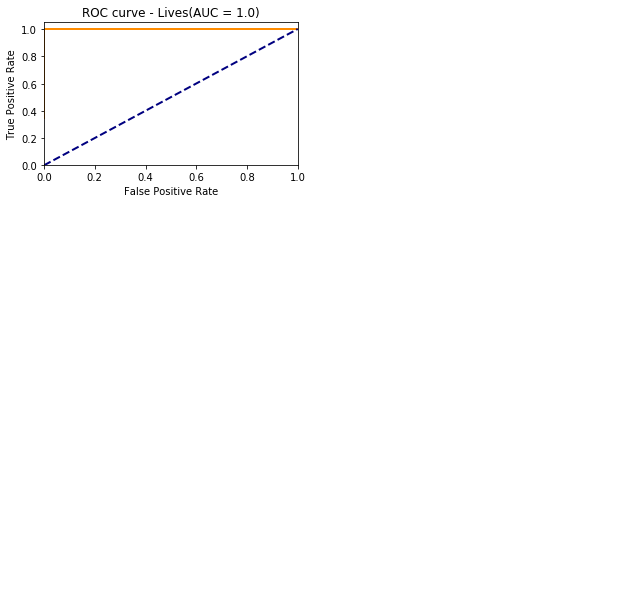

In [417]:
#from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

#preclf = MultinomialNB()

preclf = KNeighborsClassifier(weights="distance", n_neighbors=30)
preclf.fit(X_train, y_train[:,1])

prepreds = preclf.predict(X_test)
preproba = preclf.predict_proba(X_test)

print f1_score(y_test[:,1], prepreds)
print log_loss(y_test[:,1], preproba)

print X_train.shape
print y_train[:,1].shape
print y_train
X_train = np.hstack((X_train, y_train[:,1:]))

print "--"
#print np.hstack((np.transpose(prepreds[np.newaxis]), np.transpose((prepreds==0)[np.newaxis])))
#['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
#print prepreds
#print (prepreds==0).astype(int)
print prepreds.shape
print preproba.shape
#plotROCCurves([0, 1], ["Lives", "Dies"], np.hstack((np.transpose((prepreds==0)[np.newaxis]), np.transpose(prepreds[np.newaxis]))), preproba)
plotROCCurves([1], ["Lives"], np.transpose(prepreds[np.newaxis]), np.transpose(preproba[:,1][np.newaxis]))


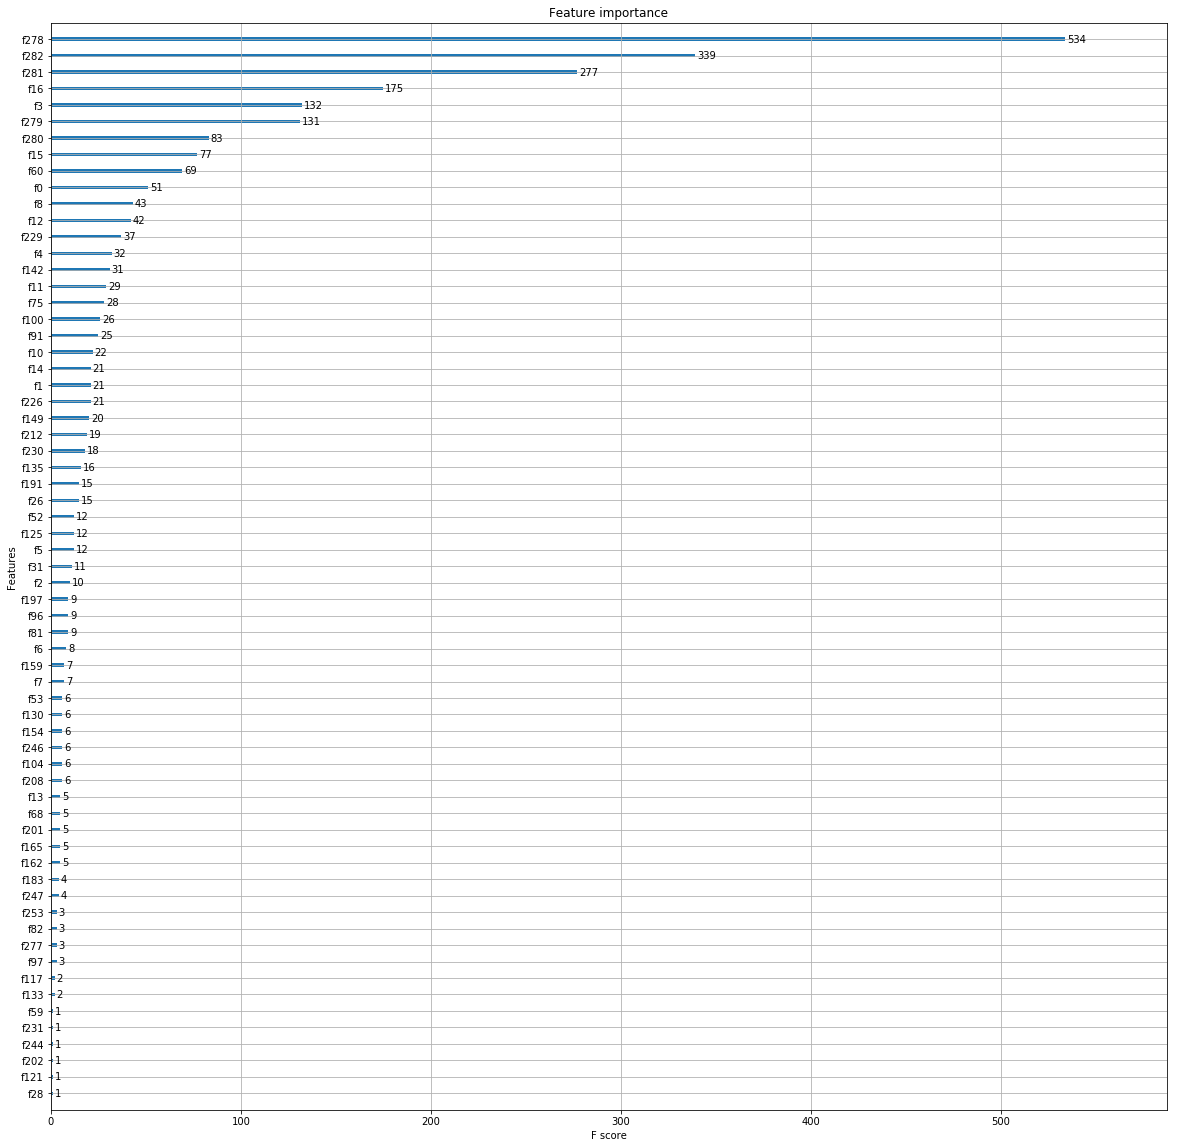

1.0
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        

In [418]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

fselGB = xgb.XGBClassifier()

fselGB.fit(X_train, y_train[:,0])

#plt.bar(range(len(GB.feature_importances_)), GB.feature_importances_)
fig, ax = plt.subplots(figsize=(20, 20))
xgb.plot_importance(fselGB, ax=ax)
plt.show()
print np.sum(fselGB.feature_importances_)
print np.sort(fselGB.feature_importances_)

thresholds_for_test = np.geomspace(0.00001, 0.1, 10, endpoint=True)
f1scores=[]
loglosses=[]
paramsleft=[]
for thresh in thresholds_for_test:
    support = fselGB.feature_importances_>thresh
    print "Threshold=", thresh, ": Re-fitting with ", np.sum(support), " features instead of ", len(support)
    
    GB2 = xgb.XGBClassifier()

    GB2.fit(X_train[:,support], y_train[:,0])

    preds = GB2.predict(np.hstack((X_test, y_test[:,1:]))[:,support])
    proba = GB2.predict_proba(np.hstack((X_test, y_test[:,1:]))[:,support])

    f1score = f1_score(y_test[:,0:1], preds, average="weighted")
    logloss = log_loss(y_test[:,0:1], proba, labels=GB2.classes_)
    print "f1 score=", f1score
    print "log loss=", logloss

    f1scores.append(f1score)
    loglosses.append(logloss)
    paramsleft.append(np.sum(support))
    
xgbresults = [thresholds_for_test, paramsleft, f1scores, loglosses]
print xgbresults
#y_test_bin = label_binarize(y_test, GB2.classes_)
#print y_test_bin
#print proba


In [420]:
xgbresults = [thresholds_for_test, paramsleft, f1scores, loglosses]
print xgbresults

[array([  1.00000000e-05,   2.78255940e-05,   7.74263683e-05,
         2.15443469e-04,   5.99484250e-04,   1.66810054e-03,
         4.64158883e-03,   1.29154967e-02,   3.59381366e-02,
         1.00000000e-01]), [65, 65, 65, 65, 59, 51, 32, 13, 6, 3], [0.72252875742985645, 0.72252875742985645, 0.72252875742985645, 0.72252875742985645, 0.72261115381873897, 0.72379718833882434, 0.72409339105896708, 0.71843967611552573, 0.69775691409359697, 0.62607879538141809], [0.61119811312424532, 0.61119811312424532, 0.61119811312424532, 0.61119811312424532, 0.61104467111552685, 0.61056833627809937, 0.60982282045556313, 0.61088235267431146, 0.63816741419259715, 0.75198464209798266]]


[  1.00000000e-05   2.78255940e-05   7.74263683e-05   2.15443469e-04
   5.99484250e-04   1.66810054e-03   4.64158883e-03   1.29154967e-02
   3.59381366e-02   1.00000000e-01]
[0.72252875742985645, 0.72252875742985645, 0.72252875742985645, 0.72252875742985645, 0.72261115381873897, 0.72379718833882434, 0.72409339105896708, 0.71843967611552573, 0.69775691409359697, 0.62607879538141809]
[0.61119811312424532, 0.61119811312424532, 0.61119811312424532, 0.61119811312424532, 0.61104467111552685, 0.61056833627809937, 0.60982282045556313, 0.61088235267431146, 0.63816741419259715, 0.75198464209798266]
Will use threshold  0.00464158883361
[ True  True False  True  True  True False False  True False  True  True
  True False  True  True  True False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
  

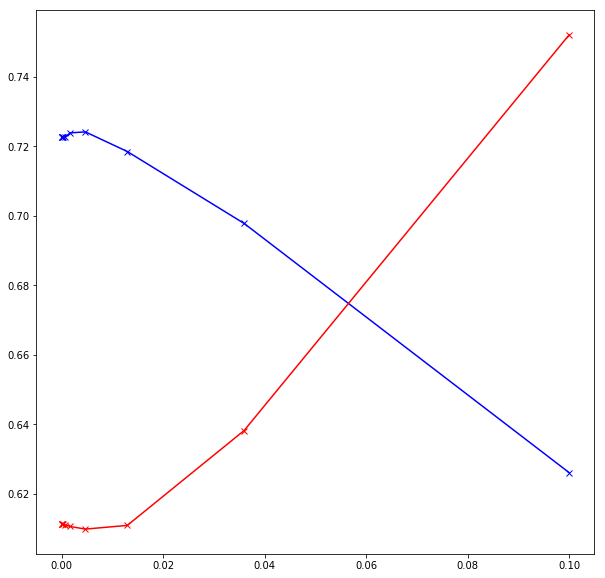

In [421]:
print thresholds_for_test
print f1scores
print loglosses

f, ax = plt.subplots(1, figsize=(10,10))
plt.plot(thresholds_for_test, f1scores, "bx-", thresholds_for_test, loglosses, "rx-")

f1_thresh = np.argsort(f1scores)[-1]
ll_thresh = np.argsort(loglosses)[0]

final_threshold = np.average((thresholds_for_test[f1_thresh], thresholds_for_test[ll_thresh]))
final_support = fselGB.feature_importances_>=final_threshold

print "Will use threshold ", final_threshold
print final_support

X_train = X_train[:,final_support]
X_test = np.hstack((X_test, y_test[:,1:]))[:,final_support]


#print prepared_fitted_df.columns[final_support[0:-1]]


In [422]:
sortedIndexes = np.argsort(fselGB.feature_importances_)[::-1]
colnames= prepared_fitted_df.columns.values
colnames = np.append(colnames, "SimpleOutcome")

print colnames[sortedIndexes][final_support[sortedIndexes]]

['AgeDays' 'SimpleOutcome' 'OutcomeHour' 'HasName' 'Neutered' 'OutcomeDay'
 'OutcomeMonth' 'IsWeekend' 'Breed_43' 'AnimalType' 'DaySegment_HR_0'
 'DaySegment_HR_4' 'Breed_212' 'PureBreed' 'Breed_125' 'DaySegment_HR_3'
 'Breed_58' 'Breed_83' 'Breed_74' 'DaySegment_HR_2' 'DaySegment_HR_6'
 'Breed_209' 'Sex_female' 'Breed_132' 'Breed_195' 'Breed_213' 'Breed_118'
 'Breed_174' 'Breed_9' 'Breed_108' 'Breed_35' 'AgeBracket_adult']


In [369]:
import xgboost as xgb
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

n_iter = 1000
k_fold = 3
  
cv = StratifiedKFold(y_train[:,0],n_folds=k_fold,shuffle=True)
  
# initialize the classifier
GB = xgb.XGBClassifier()
  
param_grid = {'max_depth': sp_randint(1, 200),
              'learning_rate': sp_uniform(loc=0e0,scale=1e0),
              'objective':['multi:softprob'],
              'n_jobs': [2],
              'missing': [np.nan],
              'reg_alpha': np.geomspace(0.01, 100, 15, endpoint=True),
              'colsample_bytree': sp_uniform(loc=0.2e0,scale=0.8e0),
              'subsample': sp_uniform(loc=0.2e0,scale=0.8e0),
              'n_estimators': sp_randint(50, 500)}
  
search_GB = RandomizedSearchCV(GB,param_grid,scoring='neg_log_loss', n_iter=n_iter,cv=cv,verbose=10, n_jobs=2).fit(X_train,y_train[:,0])
print ' ',search_GB.best_score_
print ' ',search_GB.best_params_

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.984117148485, missing=nan, learning_rate=0.723728778393, n_estimators=442, subsample=0.974384613145, objective=multi:softprob, max_depth=20 
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.984117148485, missing=nan, learning_rate=0.723728778393, n_estimators=442, subsample=0.974384613145, objective=multi:softprob, max_depth=20 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.984117148485, missing=nan, learning_rate=0.723728778393, n_estimators=442, subsample=0.974384613145, objective=multi:softprob, max_depth=20, score=-0.697455 - 1.1min


[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:  1.1min


[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.984117148485, missing=nan, learning_rate=0.723728778393, n_estimators=442, subsample=0.974384613145, objective=multi:softprob, max_depth=20 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.984117148485, missing=nan, learning_rate=0.723728778393, n_estimators=442, subsample=0.974384613145, objective=multi:softprob, max_depth=20, score=-0.711338 - 1.2min
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.279916035806, missing=nan, learning_rate=0.638200519055, n_estimators=191, subsample=0.740617608712, objective=multi:softprob, max_depth=32 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.279916035806, missing=nan, learning_rate=0.638200519055, n_estimators=191, subsample=0.740617608712, objective=multi:softprob, max_depth=32, score=-0.860224 -  22.1s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.279916035806, missing=nan, learning_rate=0.638200519055, n_estimators=191, subsampl

[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:  1.8min


[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.279916035806, missing=nan, learning_rate=0.638200519055, n_estimators=191, subsample=0.740617608712, objective=multi:softprob, max_depth=32, score=-0.841359 -  21.0s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.940266239387, missing=nan, learning_rate=0.217984302237, n_estimators=480, subsample=0.599544168799, objective=multi:softprob, max_depth=164 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.984117148485, missing=nan, learning_rate=0.723728778393, n_estimators=442, subsample=0.974384613145, objective=multi:softprob, max_depth=20, score=-0.688837 - 1.2min
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.940266239387, missing=nan, learning_rate=0.217984302237, n_estimators=480, subsample=0.599544168799, objective=multi:softprob, max_depth=164 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.940266239387, missing=nan, learning_rate=0.217984302237, n_estimators=480, sub

[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  6.1min


[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.862758767205, missing=nan, learning_rate=0.214350252972, n_estimators=480, subsample=0.470583975737, objective=multi:softprob, max_depth=147 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.940266239387, missing=nan, learning_rate=0.217984302237, n_estimators=480, subsample=0.599544168799, objective=multi:softprob, max_depth=164, score=-0.985262 - 2.2min
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.862758767205, missing=nan, learning_rate=0.214350252972, n_estimators=480, subsample=0.470583975737, objective=multi:softprob, max_depth=147 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.862758767205, missing=nan, learning_rate=0.214350252972, n_estimators=480, subsample=0.470583975737, objective=multi:softprob, max_depth=147, score=-0.952896 - 1.8min
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.659072177841, missing=nan, learning_rate=0.44787060642, n_estimators=309, subsam

[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  8.6min


[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.210912455762, missing=nan, learning_rate=0.834030994641, n_estimators=402, subsample=0.458966716025, objective=multi:softprob, max_depth=163, score=-0.789080 -  25.1s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.210912455762, missing=nan, learning_rate=0.834030994641, n_estimators=402, subsample=0.458966716025, objective=multi:softprob, max_depth=163 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.659072177841, missing=nan, learning_rate=0.44787060642, n_estimators=309, subsample=0.706165323295, objective=multi:softprob, max_depth=189, score=-0.617975 -  37.2s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.210912455762, missing=nan, learning_rate=0.834030994641, n_estimators=402, subsample=0.458966716025, objective=multi:softprob, max_depth=163 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.210912455762, missing=nan, learning_rate=0.834030994641, n_estimators=402, subsample=0.458966716025, objective=multi:softprob

[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  9.8min


[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.362842581678, missing=nan, learning_rate=0.235780898198, n_estimators=313, subsample=0.368165634494, objective=multi:softprob, max_depth=22, score=-0.678697 -  34.2s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.362842581678, missing=nan, learning_rate=0.235780898198, n_estimators=313, subsample=0.368165634494, objective=multi:softprob, max_depth=22 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.362842581678, missing=nan, learning_rate=0.235780898198, n_estimators=313, subsample=0.368165634494, objective=multi:softprob, max_depth=22, score=-0.671298 -  34.7s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.903410819747, missing=nan, learning_rate=0.643315087858, n_estimators=306, subsample=0.602992980307, objective=multi:softprob, max_depth=41 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.362842581678, missing=nan, learning_rate=0.235780898198, n_estimators=313, subsample=0.368165634494, objective=multi:softprob,

[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed: 12.7min


[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.335143132093, missing=nan, learning_rate=0.572706067758, n_estimators=253, subsample=0.379927459264, objective=multi:softprob, max_depth=160, score=-0.986567 -  26.9s
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.335143132093, missing=nan, learning_rate=0.572706067758, n_estimators=253, subsample=0.379927459264, objective=multi:softprob, max_depth=160, score=-1.012403 -  27.2s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.852878240944, missing=nan, learning_rate=0.703227354562, n_estimators=160, subsample=0.245023318252, objective=multi:softprob, max_depth=101 
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.852878240944, missing=nan, learning_rate=0.703227354562, n_estimators=160, subsample=0.245023318252, objective=multi:softprob, max_depth=101 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.852878240944, missing=nan, learning_rate=0.703227354562, n_estimators=160, subsample=0.245023318

[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed: 15.4min


[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.512020640788, missing=nan, learning_rate=0.249048848051, n_estimators=306, subsample=0.652159266622, objective=multi:softprob, max_depth=67, score=-0.880867 -  53.3s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.238771998863, missing=nan, learning_rate=0.415573707089, n_estimators=179, subsample=0.473819425468, objective=multi:softprob, max_depth=157 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.238771998863, missing=nan, learning_rate=0.415573707089, n_estimators=179, subsample=0.473819425468, objective=multi:softprob, max_depth=157, score=-0.720285 -  15.2s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.238771998863, missing=nan, learning_rate=0.415573707089, n_estimators=179, subsample=0.473819425468, objective=multi:softprob, max_depth=157 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.238771998863, missing=nan, learning_rate=0.415573707089, n_estimators=179, 

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 16.6min


[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.510474742047, missing=nan, learning_rate=0.398583789682, n_estimators=403, subsample=0.375906149089, objective=multi:softprob, max_depth=84, score=-0.728632 -  13.7s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.840509226606, missing=nan, learning_rate=0.157490474634, n_estimators=359, subsample=0.29238808571, objective=multi:softprob, max_depth=110 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.510474742047, missing=nan, learning_rate=0.398583789682, n_estimators=403, subsample=0.375906149089, objective=multi:softprob, max_depth=84, score=-0.720559 -  13.5s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.840509226606, missing=nan, learning_rate=0.157490474634, n_estimators=359, subsample=0.29238808571, objective=multi:softprob, max_depth=110 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.840509226606, missing=nan, learning_rate=0.157490474634, n_estimators=359, subsample=0.29238808571

[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 20.7min


[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.934356124793, missing=nan, learning_rate=0.320315885144, n_estimators=267, subsample=0.652970787919, objective=multi:softprob, max_depth=116, score=-1.006486 - 1.1min
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.934356124793, missing=nan, learning_rate=0.320315885144, n_estimators=267, subsample=0.652970787919, objective=multi:softprob, max_depth=116 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.934356124793, missing=nan, learning_rate=0.320315885144, n_estimators=267, subsample=0.652970787919, objective=multi:softprob, max_depth=116, score=-1.000940 - 1.1min
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.98576667464, missing=nan, learning_rate=0.763301366122, n_estimators=240, subsample=0.330984630703, objective=multi:softprob, max_depth=23 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.98576667464, missing=nan, learning_rate=0.763301366122, n_estimators=240, su

[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 24.9min


[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.984813017222, missing=nan, learning_rate=0.531107717381, n_estimators=237, subsample=0.363476678492, objective=multi:softprob, max_depth=196, score=-1.115239 -  51.6s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.344656189571, missing=nan, learning_rate=0.115403794897, n_estimators=378, subsample=0.261707741362, objective=multi:softprob, max_depth=22 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.344656189571, missing=nan, learning_rate=0.115403794897, n_estimators=378, subsample=0.261707741362, objective=multi:softprob, max_depth=22, score=-0.673034 -  41.3s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.344656189571, missing=nan, learning_rate=0.115403794897, n_estimators=378, subsample=0.261707741362, objective=multi:softprob, max_depth=22 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.344656189571, missing=nan, learning_rate=0.115403794897, n_estimators=378, subsample=0.2

[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 30.0min


[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.793798586653, missing=nan, learning_rate=0.0502134576464, n_estimators=497, subsample=0.309189907989, objective=multi:softprob, max_depth=96, score=-0.683178 -  32.7s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.793798586653, missing=nan, learning_rate=0.0502134576464, n_estimators=497, subsample=0.309189907989, objective=multi:softprob, max_depth=96 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.632612316628, missing=nan, learning_rate=0.274026086748, n_estimators=369, subsample=0.806680403591, objective=multi:softprob, max_depth=74, score=-0.962655 - 1.2min
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.386455933529, missing=nan, learning_rate=0.819200258032, n_estimators=194, subsample=0.555860350246, objective=multi:softprob, max_depth=195 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.386455933529, missing=nan, learning_rate=0.819200258032, n_estimators=194, subs

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 35.1min


[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.952127638471, missing=nan, learning_rate=0.122094187381, n_estimators=144, subsample=0.548058653532, objective=multi:softprob, max_depth=123, score=-0.720015 -  50.5s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.628695374757, missing=nan, learning_rate=0.940306325789, n_estimators=173, subsample=0.793870964644, objective=multi:softprob, max_depth=139 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.952127638471, missing=nan, learning_rate=0.122094187381, n_estimators=144, subsample=0.548058653532, objective=multi:softprob, max_depth=123, score=-0.711775 -  49.3s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.628695374757, missing=nan, learning_rate=0.940306325789, n_estimators=173, subsample=0.793870964644, objective=multi:softprob, max_depth=139 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.628695374757, missing=nan, learning_rate=0.940306325789, n_estimators=173, subsamp

[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 39.4min


[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.661007983799, missing=nan, learning_rate=0.456591332496, n_estimators=473, subsample=0.971160524489, objective=multi:softprob, max_depth=177, score=-0.661769 - 1.0min
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.441003073423, missing=nan, learning_rate=0.214669506102, n_estimators=137, subsample=0.24307528095, objective=multi:softprob, max_depth=135 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.441003073423, missing=nan, learning_rate=0.214669506102, n_estimators=137, subsample=0.24307528095, objective=multi:softprob, max_depth=135, score=-0.674477 -   7.4s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.441003073423, missing=nan, learning_rate=0.214669506102, n_estimators=137, subsample=0.24307528095, objective=multi:softprob, max_depth=135 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.441003073423, missing=nan, learning_rate=0.214669506102, n_estimators=137, subsample=0.

[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 42.8min


[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.45317312835, missing=nan, learning_rate=0.8430336629, n_estimators=440, subsample=0.829804205772, objective=multi:softprob, max_depth=195, score=-0.764792 -  52.9s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.298102320462, missing=nan, learning_rate=0.12617415257, n_estimators=344, subsample=0.874978429362, objective=multi:softprob, max_depth=22 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.934001589466, missing=nan, learning_rate=0.632913592565, n_estimators=241, subsample=0.756220838892, objective=multi:softprob, max_depth=15, score=-0.631432 -  13.2s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.298102320462, missing=nan, learning_rate=0.12617415257, n_estimators=344, subsample=0.874978429362, objective=multi:softprob, max_depth=22 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.298102320462, missing=nan, learning_rate=0.12617415257, n_estimators=344, subsample=0.874

[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 48.2min


[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.862135740126, missing=nan, learning_rate=0.780946364916, n_estimators=251, subsample=0.943403483432, objective=multi:softprob, max_depth=87, score=-1.056456 -  47.8s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.862135740126, missing=nan, learning_rate=0.780946364916, n_estimators=251, subsample=0.943403483432, objective=multi:softprob, max_depth=87 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.862135740126, missing=nan, learning_rate=0.780946364916, n_estimators=251, subsample=0.943403483432, objective=multi:softprob, max_depth=87, score=-1.052641 -  52.0s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.344209877856, missing=nan, learning_rate=0.345611075175, n_estimators=209, subsample=0.367424673703, objective=multi:softprob, max_depth=92 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.862135740126, missing=nan, learning_rate=0.780946364916, n_estimators=251, subsample

[Parallel(n_jobs=2)]: Done 158 tasks      | elapsed: 52.3min


[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.262843453879, missing=nan, learning_rate=0.98495063779, n_estimators=470, subsample=0.705224896638, objective=multi:softprob, max_depth=107, score=-0.651856 -  13.7s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.262843453879, missing=nan, learning_rate=0.98495063779, n_estimators=470, subsample=0.705224896638, objective=multi:softprob, max_depth=107 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.262843453879, missing=nan, learning_rate=0.98495063779, n_estimators=470, subsample=0.705224896638, objective=multi:softprob, max_depth=107, score=-0.644078 -  15.2s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.262843453879, missing=nan, learning_rate=0.98495063779, n_estimators=470, subsample=0.705224896638, objective=multi:softprob, max_depth=107 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.945409064677, missing=nan, learning_rate=0.0375002463993, n_estimators=427, subsample=0.

[Parallel(n_jobs=2)]: Done 177 tasks      | elapsed: 56.8min


[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.52239285087, missing=nan, learning_rate=0.691586973522, n_estimators=296, subsample=0.40857520719, objective=multi:softprob, max_depth=160, score=-1.056021 -  38.6s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.452966056473, missing=nan, learning_rate=0.0533546007125, n_estimators=281, subsample=0.240384015439, objective=multi:softprob, max_depth=190 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.452966056473, missing=nan, learning_rate=0.0533546007125, n_estimators=281, subsample=0.240384015439, objective=multi:softprob, max_depth=190, score=-0.600486 -  26.4s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.820843576051, missing=nan, learning_rate=0.146176113425, n_estimators=218, subsample=0.848285725023, objective=multi:softprob, max_depth=33 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.452966056473, missing=nan, learning_rate=0.0533546007125, n_estimators=281, subsample=0.2403

[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 61.9min


[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.787376296847, missing=nan, learning_rate=0.914818629518, n_estimators=223, subsample=0.752830059199, objective=multi:softprob, max_depth=177, score=-1.154323 -  40.6s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.386224866377, missing=nan, learning_rate=0.0700453154323, n_estimators=179, subsample=0.203892972645, objective=multi:softprob, max_depth=124 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.386224866377, missing=nan, learning_rate=0.0700453154323, n_estimators=179, subsample=0.203892972645, objective=multi:softprob, max_depth=124, score=-0.617510 -  17.8s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.386224866377, missing=nan, learning_rate=0.0700453154323, n_estimators=179, subsample=0.203892972645, objective=multi:softprob, max_depth=124 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.787376296847, missing=nan, learning_rate=0.914818629518, n_estimators=223,

[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.61811070708, missing=nan, learning_rate=0.185067746574, n_estimators=279, subsample=0.407619707753, objective=multi:softprob, max_depth=165 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.61811070708, missing=nan, learning_rate=0.185067746574, n_estimators=279, subsample=0.407619707753, objective=multi:softprob, max_depth=165, score=-0.800058 - 1.0min
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.61811070708, missing=nan, learning_rate=0.185067746574, n_estimators=279, subsample=0.407619707753, objective=multi:softprob, max_depth=165 


[Parallel(n_jobs=2)]: Done 217 tasks      | elapsed: 68.3min


[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.61811070708, missing=nan, learning_rate=0.185067746574, n_estimators=279, subsample=0.407619707753, objective=multi:softprob, max_depth=165, score=-0.797428 - 1.0min
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.584037212346, missing=nan, learning_rate=0.397641600061, n_estimators=311, subsample=0.818921126803, objective=multi:softprob, max_depth=147 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.61811070708, missing=nan, learning_rate=0.185067746574, n_estimators=279, subsample=0.407619707753, objective=multi:softprob, max_depth=165, score=-0.791216 -  55.3s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.584037212346, missing=nan, learning_rate=0.397641600061, n_estimators=311, subsample=0.818921126803, objective=multi:softprob, max_depth=147 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.584037212346, missing=nan, learning_rate=0.397641600061, n_estimators=311, sub

[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.783247857748, missing=nan, learning_rate=0.614554887434, n_estimators=362, subsample=0.330131902646, objective=multi:softprob, max_depth=105 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.783247857748, missing=nan, learning_rate=0.614554887434, n_estimators=362, subsample=0.330131902646, objective=multi:softprob, max_depth=105, score=-0.644096 -  45.7s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.783247857748, missing=nan, learning_rate=0.614554887434, n_estimators=362, subsample=0.330131902646, objective=multi:softprob, max_depth=105 


[Parallel(n_jobs=2)]: Done 238 tasks      | elapsed: 75.3min


[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.648253572116, missing=nan, learning_rate=0.120471739845, n_estimators=470, subsample=0.46003958229, objective=multi:softprob, max_depth=165, score=-0.831160 - 1.7min
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.428054512981, missing=nan, learning_rate=0.829812106487, n_estimators=430, subsample=0.402038252316, objective=multi:softprob, max_depth=164 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.783247857748, missing=nan, learning_rate=0.614554887434, n_estimators=362, subsample=0.330131902646, objective=multi:softprob, max_depth=105, score=-0.650257 -  43.4s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.428054512981, missing=nan, learning_rate=0.829812106487, n_estimators=430, subsample=0.402038252316, objective=multi:softprob, max_depth=164 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.428054512981, missing=nan, learning_rate=0.829812106487, n_estimators=430, subsample=0.4020

[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.242677748234, missing=nan, learning_rate=0.259201263996, n_estimators=240, subsample=0.53913357396, objective=multi:softprob, max_depth=46 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.242677748234, missing=nan, learning_rate=0.259201263996, n_estimators=240, subsample=0.53913357396, objective=multi:softprob, max_depth=46, score=-0.610331 -  16.1s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.242677748234, missing=nan, learning_rate=0.259201263996, n_estimators=240, subsample=0.53913357396, objective=multi:softprob, max_depth=46 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.242677748234, missing=nan, learning_rate=0.259201263996, n_estimators=240, subsample=0.53913357396, objective=multi:softprob, max_depth=46, score=-0.593970 -  17.3s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.633843343423, missing=nan, learning_rate=0.395573610583, n_estimators=338, subsample=0.234245

[Parallel(n_jobs=2)]: Done 261 tasks      | elapsed: 82.6min


[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.633843343423, missing=nan, learning_rate=0.395573610583, n_estimators=338, subsample=0.234245113671, objective=multi:softprob, max_depth=106, score=-0.748750 -  43.3s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.633843343423, missing=nan, learning_rate=0.395573610583, n_estimators=338, subsample=0.234245113671, objective=multi:softprob, max_depth=106 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.633843343423, missing=nan, learning_rate=0.395573610583, n_estimators=338, subsample=0.234245113671, objective=multi:softprob, max_depth=106, score=-0.735133 -  43.1s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.718170603162, missing=nan, learning_rate=0.714986524428, n_estimators=343, subsample=0.564453028533, objective=multi:softprob, max_depth=146 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.633843343423, missing=nan, learning_rate=0.395573610583, n_estimators=338, subsamp

[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.534397935069, missing=nan, learning_rate=0.150371413303, n_estimators=332, subsample=0.273977366599, objective=multi:softprob, max_depth=160 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.849482339627, missing=nan, learning_rate=0.154023717603, n_estimators=246, subsample=0.47293678606, objective=multi:softprob, max_depth=170, score=-0.730472 -  58.7s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.534397935069, missing=nan, learning_rate=0.150371413303, n_estimators=332, subsample=0.273977366599, objective=multi:softprob, max_depth=160 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.534397935069, missing=nan, learning_rate=0.150371413303, n_estimators=332, subsample=0.273977366599, objective=multi:softprob, max_depth=160, score=-0.670358 -  42.6s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.534397935069, missing=nan, learning_rate=0.150371413303, n_estimators=332, subsample=0.273977366599, objective=multi:softprob

[Parallel(n_jobs=2)]: Done 284 tasks      | elapsed: 92.3min


[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.534397935069, missing=nan, learning_rate=0.150371413303, n_estimators=332, subsample=0.273977366599, objective=multi:softprob, max_depth=160, score=-0.655961 -  46.7s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.61485591919, missing=nan, learning_rate=0.920380345948, n_estimators=399, subsample=0.705897063289, objective=multi:softprob, max_depth=9 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.61485591919, missing=nan, learning_rate=0.920380345948, n_estimators=399, subsample=0.705897063289, objective=multi:softprob, max_depth=9, score=-0.864005 -  46.1s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.61485591919, missing=nan, learning_rate=0.920380345948, n_estimators=399, subsample=0.705897063289, objective=multi:softprob, max_depth=9 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.61485591919, missing=nan, learning_rate=0.920380345948, n_estimators=399, subsample=0.705897063289, obj

[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.558744405886, missing=nan, learning_rate=0.416505754047, n_estimators=115, subsample=0.470852638543, objective=multi:softprob, max_depth=176 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.905871274171, missing=nan, learning_rate=0.553130523368, n_estimators=416, subsample=0.249995768244, objective=multi:softprob, max_depth=50, score=-1.185614 - 1.2min
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.614341198627, missing=nan, learning_rate=0.650762528106, n_estimators=343, subsample=0.442989355959, objective=multi:softprob, max_depth=78 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.558744405886, missing=nan, learning_rate=0.416505754047, n_estimators=115, subsample=0.470852638543, objective=multi:softprob, max_depth=176, score=-0.818963 -  20.9s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.614341198627, missing=nan, learning_rate=0.650762528106, n_estimators=343, subsa

[Parallel(n_jobs=2)]: Done 309 tasks      | elapsed: 100.2min


[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.633688093038, missing=nan, learning_rate=0.47322317569, n_estimators=276, subsample=0.779670580543, objective=multi:softprob, max_depth=123, score=-1.036674 -  52.0s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.633688093038, missing=nan, learning_rate=0.47322317569, n_estimators=276, subsample=0.779670580543, objective=multi:softprob, max_depth=123 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.633688093038, missing=nan, learning_rate=0.47322317569, n_estimators=276, subsample=0.779670580543, objective=multi:softprob, max_depth=123, score=-1.036912 -  55.0s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.28662304868, missing=nan, learning_rate=0.456578949207, n_estimators=380, subsample=0.333909179116, objective=multi:softprob, max_depth=55 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.633688093038, missing=nan, learning_rate=0.47322317569, n_estimators=276, subsam

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.300853032357, missing=nan, learning_rate=0.417429907832, n_estimators=192, subsample=0.668568925679, objective=multi:softprob, max_depth=133 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.300853032357, missing=nan, learning_rate=0.417429907832, n_estimators=192, subsample=0.668568925679, objective=multi:softprob, max_depth=133, score=-0.808269 -  23.7s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.300853032357, missing=nan, learning_rate=0.417429907832, n_estimators=192, subsample=0.668568925679, objective=multi:softprob, max_depth=133 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.575473261596, missing=nan, learning_rate=0.983252752289, n_estimators=208, subsample=0.585053746976, objective=multi:softprob, max_depth=166, score=-1.216486 -  36.8s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.300853032357, missing=nan, learning_rate=0.417429907832, n_estimators=192, subsample=0.668568925679, objective=multi:so

[Parallel(n_jobs=2)]: Done 334 tasks      | elapsed: 105.8min


[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.627232935335, missing=nan, learning_rate=0.296213094953, n_estimators=433, subsample=0.544198453159, objective=multi:softprob, max_depth=157, score=-0.648316 -  20.2s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.673051389431, missing=nan, learning_rate=0.388692941262, n_estimators=285, subsample=0.503822735388, objective=multi:softprob, max_depth=51 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.673051389431, missing=nan, learning_rate=0.388692941262, n_estimators=285, subsample=0.503822735388, objective=multi:softprob, max_depth=51, score=-0.658114 -  14.8s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.673051389431, missing=nan, learning_rate=0.388692941262, n_estimators=285, subsample=0.503822735388, objective=multi:softprob, max_depth=51 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.627232935335, missing=nan, learning_rate=0.296213094953, n_estimators=433, subsample=0.

[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.358626598635, missing=nan, learning_rate=0.434156144507, n_estimators=219, subsample=0.210544205303, objective=multi:softprob, max_depth=96 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.358626598635, missing=nan, learning_rate=0.434156144507, n_estimators=219, subsample=0.210544205303, objective=multi:softprob, max_depth=96, score=-0.898840 -  24.5s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.358626598635, missing=nan, learning_rate=0.434156144507, n_estimators=219, subsample=0.210544205303, objective=multi:softprob, max_depth=96 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.358626598635, missing=nan, learning_rate=0.434156144507, n_estimators=219, subsample=0.210544205303, objective=multi:softprob, max_depth=96, score=-0.912966 -  23.6s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.875177985368, missing=nan, learning_rate=0.160742035551, n_estimators=264, subs

[Parallel(n_jobs=2)]: Done 361 tasks      | elapsed: 112.2min


[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.628568114028, missing=nan, learning_rate=0.34750609826, n_estimators=449, subsample=0.276426949432, objective=multi:softprob, max_depth=46, score=-0.608378 -  31.8s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.475699235583, missing=nan, learning_rate=0.977219777676, n_estimators=360, subsample=0.563626068106, objective=multi:softprob, max_depth=82 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.628568114028, missing=nan, learning_rate=0.34750609826, n_estimators=449, subsample=0.276426949432, objective=multi:softprob, max_depth=46, score=-0.611580 -  33.0s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.475699235583, missing=nan, learning_rate=0.977219777676, n_estimators=360, subsample=0.563626068106, objective=multi:softprob, max_depth=82 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.475699235583, missing=nan, learning_rate=0.977219777676, n_estimators=360, subsample

[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.83590015184, missing=nan, learning_rate=0.384270771403, n_estimators=231, subsample=0.467457390413, objective=multi:softprob, max_depth=177 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.83590015184, missing=nan, learning_rate=0.384270771403, n_estimators=231, subsample=0.467457390413, objective=multi:softprob, max_depth=177, score=-0.631879 -  19.8s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.83590015184, missing=nan, learning_rate=0.384270771403, n_estimators=231, subsample=0.467457390413, objective=multi:softprob, max_depth=177 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.83590015184, missing=nan, learning_rate=0.384270771403, n_estimators=231, subsample=0.467457390413, objective=multi:softprob, max_depth=177, score=-0.616089 -  19.1s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.727068255732, missing=nan, learning_rate=0.478846191094, n_estimators=330, subsample=0.7

[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed: 121.4min


[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.880101060548, missing=nan, learning_rate=0.768864303771, n_estimators=419, subsample=0.692151686389, objective=multi:softprob, max_depth=147, score=-0.766663 - 1.2min
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.281468572958, missing=nan, learning_rate=0.901117752012, n_estimators=53, subsample=0.705317394269, objective=multi:softprob, max_depth=174 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.281468572958, missing=nan, learning_rate=0.901117752012, n_estimators=53, subsample=0.705317394269, objective=multi:softprob, max_depth=174, score=-0.724372 -   5.1s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.281468572958, missing=nan, learning_rate=0.901117752012, n_estimators=53, subsample=0.705317394269, objective=multi:softprob, max_depth=174 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.281468572958, missing=nan, learning_rate=0.901117752012, n_estimators=53, subsample

[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.724637890422, missing=nan, learning_rate=0.115325389134, n_estimators=405, subsample=0.210436499669, objective=multi:softprob, max_depth=2 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.724637890422, missing=nan, learning_rate=0.115325389134, n_estimators=405, subsample=0.210436499669, objective=multi:softprob, max_depth=2, score=-0.614632 -  18.7s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.724637890422, missing=nan, learning_rate=0.115325389134, n_estimators=405, subsample=0.210436499669, objective=multi:softprob, max_depth=2 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.724637890422, missing=nan, learning_rate=0.115325389134, n_estimators=405, subsample=0.210436499669, objective=multi:softprob, max_depth=2, score=-0.606064 -  18.5s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.990350997937, missing=nan, learning_rate=0.279813264151, n_estimators=156, subsample=0.

[Parallel(n_jobs=2)]: Done 417 tasks      | elapsed: 128.8min


[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.612384108852, missing=nan, learning_rate=0.178830646904, n_estimators=63, subsample=0.91116110923, objective=multi:softprob, max_depth=34, score=-0.627005 -  15.8s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.651932983635, missing=nan, learning_rate=0.623389920476, n_estimators=155, subsample=0.582201740127, objective=multi:softprob, max_depth=2 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.651932983635, missing=nan, learning_rate=0.623389920476, n_estimators=155, subsample=0.582201740127, objective=multi:softprob, max_depth=2, score=-0.605852 -   7.7s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.545608085901, missing=nan, learning_rate=0.177340145904, n_estimators=65, subsample=0.254511398309, objective=multi:softprob, max_depth=63 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.651932983635, missing=nan, learning_rate=0.623389920476, n_estimators=155, subsample=0.582201740127, objective=multi:sof

[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.602876320152, missing=nan, learning_rate=0.465714350234, n_estimators=469, subsample=0.576649248488, objective=multi:softprob, max_depth=189 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.602876320152, missing=nan, learning_rate=0.465714350234, n_estimators=469, subsample=0.576649248488, objective=multi:softprob, max_depth=189, score=-0.654591 -  23.0s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.602876320152, missing=nan, learning_rate=0.465714350234, n_estimators=469, subsample=0.576649248488, objective=multi:softprob, max_depth=189 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.602876320152, missing=nan, learning_rate=0.465714350234, n_estimators=469, subsample=0.576649248488, objective=multi:softprob, max_depth=189, score=-0.642613 -  19.8s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.602876320152, missing=nan, learning_rate=0.465714350234, n_estimators=469, subsample=

[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 137.0min


[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.40282745748, missing=nan, learning_rate=0.0835353512178, n_estimators=90, subsample=0.240295744465, objective=multi:softprob, max_depth=78, score=-0.634736 -  13.6s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.40282745748, missing=nan, learning_rate=0.0835353512178, n_estimators=90, subsample=0.240295744465, objective=multi:softprob, max_depth=78 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.701131757343, missing=nan, learning_rate=0.178803674132, n_estimators=428, subsample=0.911449178348, objective=multi:softprob, max_depth=75, score=-0.720308 - 1.5min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.40282745748, missing=nan, learning_rate=0.0835353512178, n_estimators=90, subsample=0.240295744465, objective=multi:softprob, max_depth=78 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.40282745748, missing=nan, learning_rate=0.0835353512178, n_estimators=90, subsample=0.240295744465, objective=multi:softprob, max_depth=7

[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.879822157417, missing=nan, learning_rate=0.654196965662, n_estimators=349, subsample=0.405951715275, objective=multi:softprob, max_depth=2 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.879822157417, missing=nan, learning_rate=0.654196965662, n_estimators=349, subsample=0.405951715275, objective=multi:softprob, max_depth=2, score=-0.631736 -  21.2s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.244813523335, missing=nan, learning_rate=0.603535291018, n_estimators=192, subsample=0.665865154593, objective=multi:softprob, max_depth=42 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.244813523335, missing=nan, learning_rate=0.603535291018, n_estimators=192, subsample=0.665865154593, objective=multi:softprob, max_depth=42, score=-0.723209 -  17.5s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.244813523335, missing=nan, learning_rate=0.603535291018, n_estimators=192, subsample

[Parallel(n_jobs=2)]: Done 477 tasks      | elapsed: 147.6min


[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.343661114508, missing=nan, learning_rate=0.924656787846, n_estimators=307, subsample=0.581664094516, objective=multi:softprob, max_depth=145, score=-1.191878 -  36.3s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.343661114508, missing=nan, learning_rate=0.924656787846, n_estimators=307, subsample=0.581664094516, objective=multi:softprob, max_depth=145 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.343661114508, missing=nan, learning_rate=0.924656787846, n_estimators=307, subsample=0.581664094516, objective=multi:softprob, max_depth=145, score=-1.161958 -  35.6s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.320510207542, missing=nan, learning_rate=0.324961878458, n_estimators=114, subsample=0.865997630508, objective=multi:softprob, max_depth=86 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.320510207542, missing=nan, learning_rate=0.324961878458, n_estimators=114, subs

[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.938535079467, missing=nan, learning_rate=0.594830524972, n_estimators=339, subsample=0.912824905201, objective=multi:softprob, max_depth=89, score=-0.658041 -  13.4s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.685876765251, missing=nan, learning_rate=0.436579533352, n_estimators=133, subsample=0.70560700341, objective=multi:softprob, max_depth=51 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.685876765251, missing=nan, learning_rate=0.436579533352, n_estimators=133, subsample=0.70560700341, objective=multi:softprob, max_depth=51, score=-0.628149 -  10.7s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.685876765251, missing=nan, learning_rate=0.436579533352, n_estimators=133, subsample=0.70560700341, objective=multi:softprob, max_depth=51 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.685876765251, missing=nan, learning_rate=0.436579533352, n_estimators=133, subsample=0.70560700341,

[Parallel(n_jobs=2)]: Done 508 tasks      | elapsed: 154.6min


[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.955549418689, missing=nan, learning_rate=0.0621701572602, n_estimators=278, subsample=0.859033437929, objective=multi:softprob, max_depth=157, score=-0.627296 - 1.3min
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.68608812435, missing=nan, learning_rate=0.116768837741, n_estimators=67, subsample=0.521318458652, objective=multi:softprob, max_depth=145 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.68608812435, missing=nan, learning_rate=0.116768837741, n_estimators=67, subsample=0.521318458652, objective=multi:softprob, max_depth=145, score=-0.637077 -   7.6s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.68608812435, missing=nan, learning_rate=0.116768837741, n_estimators=67, subsample=0.521318458652, objective=multi:softprob, max_depth=145 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.68608812435, missing=nan, learning_rate=0.116768837741, n_estimators=67, subsample=0.5213

[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.673032256961, missing=nan, learning_rate=0.193491984393, n_estimators=342, subsample=0.643942121419, objective=multi:softprob, max_depth=142, score=-0.887490 - 1.4min
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.542512086742, missing=nan, learning_rate=0.057172573613, n_estimators=387, subsample=0.244203729894, objective=multi:softprob, max_depth=115 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.542512086742, missing=nan, learning_rate=0.057172573613, n_estimators=387, subsample=0.244203729894, objective=multi:softprob, max_depth=115, score=-0.634421 - 1.0min
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.933947245748, missing=nan, learning_rate=0.0523798483545, n_estimators=334, subsample=0.732586072801, objective=multi:softprob, max_depth=15 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.542512086742, missing=nan, learning_rate=0.057172573613, n_estimators=387, subsample=0.244203729894,

[Parallel(n_jobs=2)]: Done 541 tasks      | elapsed: 167.2min


[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.765078559408, missing=nan, learning_rate=0.370494470022, n_estimators=185, subsample=0.733854450316, objective=multi:softprob, max_depth=104, score=-0.699114 -  35.7s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.275630014091, missing=nan, learning_rate=0.901980557919, n_estimators=491, subsample=0.577977347379, objective=multi:softprob, max_depth=158 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.765078559408, missing=nan, learning_rate=0.370494470022, n_estimators=185, subsample=0.733854450316, objective=multi:softprob, max_depth=104, score=-0.695387 -  35.7s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.275630014091, missing=nan, learning_rate=0.901980557919, n_estimators=491, subsample=0.577977347379, objective=multi:softprob, max_depth=158 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.275630014091, missing=nan, learning_rate=0.901980557919, n_estimators=491, subsample

[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.759091497327, missing=nan, learning_rate=0.703987847023, n_estimators=143, subsample=0.763268148016, objective=multi:softprob, max_depth=46 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.759091497327, missing=nan, learning_rate=0.703987847023, n_estimators=143, subsample=0.763268148016, objective=multi:softprob, max_depth=46, score=-0.618944 -  16.6s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.759091497327, missing=nan, learning_rate=0.703987847023, n_estimators=143, subsample=0.763268148016, objective=multi:softprob, max_depth=46 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.759091497327, missing=nan, learning_rate=0.703987847023, n_estimators=143, subsample=0.763268148016, objective=multi:softprob, max_depth=46, score=-0.606509 -  16.0s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.556423724823, missing=nan, learning_rate=0.985264503548, n_estimators=200, subsample=0.4

[Parallel(n_jobs=2)]: Done 574 tasks      | elapsed: 176.7min


[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.760600366721, missing=nan, learning_rate=0.476825106343, n_estimators=360, subsample=0.232935765588, objective=multi:softprob, max_depth=26, score=-1.189393 - 1.1min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.717601859973, missing=nan, learning_rate=0.636503832257, n_estimators=172, subsample=0.705896335143, objective=multi:softprob, max_depth=192 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.894288176092, missing=nan, learning_rate=0.871871957562, n_estimators=236, subsample=0.854264119207, objective=multi:softprob, max_depth=189, score=-0.633407 -  11.3s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.717601859973, missing=nan, learning_rate=0.636503832257, n_estimators=172, subsample=0.705896335143, objective=multi:softprob, max_depth=192 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.717601859973, missing=nan, learning_rate=0.636503832257, n_estimators=172, subsample=0.705896335143, objective

[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.60079132349, missing=nan, learning_rate=0.344245609073, n_estimators=357, subsample=0.34093460681, objective=multi:softprob, max_depth=117, score=-0.733951 -  14.3s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.60079132349, missing=nan, learning_rate=0.344245609073, n_estimators=357, subsample=0.34093460681, objective=multi:softprob, max_depth=117 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.60079132349, missing=nan, learning_rate=0.344245609073, n_estimators=357, subsample=0.34093460681, objective=multi:softprob, max_depth=117, score=-0.737604 -  14.9s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.801996854693, missing=nan, learning_rate=0.145808584685, n_estimators=246, subsample=0.989296713934, objective=multi:softprob, max_depth=93 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.60079132349, missing=nan, learning_rate=0.344245609073, n_estimators=357, subsample=0.34093460681, objective=multi:softprob

[Parallel(n_jobs=2)]: Done 609 tasks      | elapsed: 187.0min


[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.207561915219, missing=nan, learning_rate=0.535798302067, n_estimators=107, subsample=0.703473946955, objective=multi:softprob, max_depth=123, score=-0.650485 -   8.4s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.207561915219, missing=nan, learning_rate=0.535798302067, n_estimators=107, subsample=0.703473946955, objective=multi:softprob, max_depth=123 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.207561915219, missing=nan, learning_rate=0.535798302067, n_estimators=107, subsample=0.703473946955, objective=multi:softprob, max_depth=123, score=-0.648318 -   9.2s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.894690420452, missing=nan, learning_rate=0.0125903498588, n_estimators=473, subsample=0.971415620457, objective=multi:softprob, max_depth=83 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.858396031182, missing=nan, learning_rate=0.291673703836, n_estimators=470, s

[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.934141913559, missing=nan, learning_rate=0.770098722596, n_estimators=452, subsample=0.462671669803, objective=multi:softprob, max_depth=185 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.934141913559, missing=nan, learning_rate=0.770098722596, n_estimators=452, subsample=0.462671669803, objective=multi:softprob, max_depth=185, score=-0.627238 -  41.7s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.934141913559, missing=nan, learning_rate=0.770098722596, n_estimators=452, subsample=0.462671669803, objective=multi:softprob, max_depth=185 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.810112339198, missing=nan, learning_rate=0.962680685394, n_estimators=476, subsample=0.71324361309, objective=multi:softprob, max_depth=66, score=-0.890408 - 1.3min
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.934141913559, missing=nan, learning_rate=0.770098722596, n_estimators=452, subsample=0.

[Parallel(n_jobs=2)]: Done 644 tasks      | elapsed: 203.9min


[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.836253676026, missing=nan, learning_rate=0.352252460021, n_estimators=145, subsample=0.908972551761, objective=multi:softprob, max_depth=79, score=-0.664700 -   8.8s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.836253676026, missing=nan, learning_rate=0.352252460021, n_estimators=145, subsample=0.908972551761, objective=multi:softprob, max_depth=79 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.543921523441, missing=nan, learning_rate=0.26604299267, n_estimators=236, subsample=0.885193111555, objective=multi:softprob, max_depth=20, score=-0.613197 -  16.5s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.836253676026, missing=nan, learning_rate=0.352252460021, n_estimators=145, subsample=0.908972551761, objective=multi:softprob, max_depth=79 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.836253676026, missing=nan, learning_rate=0.352252460021, n_estimators=145, subsample=0.908972551761, objective=multi:soft

[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.88657821123, missing=nan, learning_rate=0.870484788022, n_estimators=151, subsample=0.934265091462, objective=multi:softprob, max_depth=25 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.88657821123, missing=nan, learning_rate=0.870484788022, n_estimators=151, subsample=0.934265091462, objective=multi:softprob, max_depth=25, score=-0.631323 -   7.1s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.693580253892, missing=nan, learning_rate=0.411094333186, n_estimators=361, subsample=0.242063939981, objective=multi:softprob, max_depth=45 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.922344406068, missing=nan, learning_rate=0.445516025733, n_estimators=441, subsample=0.805296792485, objective=multi:softprob, max_depth=117, score=-1.131615 - 1.7min
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.693580253892, missing=nan, learning_rate=0.411094333186, n_estimators=361, subsample

[Parallel(n_jobs=2)]: Done 681 tasks      | elapsed: 216.0min


[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.679405020918, missing=nan, learning_rate=0.390019783429, n_estimators=102, subsample=0.914486136582, objective=multi:softprob, max_depth=192, score=-0.852618 -  29.5s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.964334492487, missing=nan, learning_rate=0.0304730231609, n_estimators=196, subsample=0.408538144776, objective=multi:softprob, max_depth=51 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.964334492487, missing=nan, learning_rate=0.0304730231609, n_estimators=196, subsample=0.408538144776, objective=multi:softprob, max_depth=51, score=-0.745962 -  23.4s
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.964334492487, missing=nan, learning_rate=0.0304730231609, n_estimators=196, subsample=0.408538144776, objective=multi:softprob, max_depth=51, score=-0.752097 -  24.1s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.979085547668, missing=nan, learning_rate=0.0390590766938, n_estimators=358, subsa

[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.439209341907, missing=nan, learning_rate=0.603784890243, n_estimators=372, subsample=0.325915353904, objective=multi:softprob, max_depth=184 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.665235073642, missing=nan, learning_rate=0.0381010395659, n_estimators=493, subsample=0.763641981823, objective=multi:softprob, max_depth=114, score=-0.642348 -  37.7s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.439209341907, missing=nan, learning_rate=0.603784890243, n_estimators=372, subsample=0.325915353904, objective=multi:softprob, max_depth=184 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.439209341907, missing=nan, learning_rate=0.603784890243, n_estimators=372, subsample=0.325915353904, objective=multi:softprob, max_depth=184, score=-0.890679 -  38.1s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.439209341907, missing=nan, learning_rate=0.603784890243, n_estimators=372, subsample=0.325915353904, objective=multi:softpro

[Parallel(n_jobs=2)]: Done 718 tasks      | elapsed: 225.5min


[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.789650289245, missing=nan, learning_rate=0.435853628569, n_estimators=370, subsample=0.615460925327, objective=multi:softprob, max_depth=64, score=-0.681321 -  17.8s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.423054577039, missing=nan, learning_rate=0.836342527447, n_estimators=301, subsample=0.319619745713, objective=multi:softprob, max_depth=152 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.789650289245, missing=nan, learning_rate=0.435853628569, n_estimators=370, subsample=0.615460925327, objective=multi:softprob, max_depth=64, score=-0.673982 -  15.1s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.423054577039, missing=nan, learning_rate=0.836342527447, n_estimators=301, subsample=0.319619745713, objective=multi:softprob, max_depth=152 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.423054577039, missing=nan, learning_rate=0.836342527447, n_estimators=301, subsample=0.319619745713, objective=multi:softprob, ma

[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.263871880885, missing=nan, learning_rate=0.810617663473, n_estimators=252, subsample=0.818558787358, objective=multi:softprob, max_depth=199, score=-0.616876 -   9.0s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.263871880885, missing=nan, learning_rate=0.810617663473, n_estimators=252, subsample=0.818558787358, objective=multi:softprob, max_depth=199 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.263871880885, missing=nan, learning_rate=0.810617663473, n_estimators=252, subsample=0.818558787358, objective=multi:softprob, max_depth=199, score=-0.617525 -   9.8s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.821824350557, missing=nan, learning_rate=0.712025469204, n_estimators=268, subsample=0.483886792164, objective=multi:softprob, max_depth=139 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.221136442414, missing=nan, learning_rate=0.663716723113, n_estimators=483, subsam

[Parallel(n_jobs=2)]: Done 757 tasks      | elapsed: 235.7min


[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.764235165654, missing=nan, learning_rate=0.0972711319557, n_estimators=304, subsample=0.69545532705, objective=multi:softprob, max_depth=186, score=-0.792559 - 1.6min
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.677251993444, missing=nan, learning_rate=0.602085610896, n_estimators=499, subsample=0.206449624685, objective=multi:softprob, max_depth=160 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.677251993444, missing=nan, learning_rate=0.602085610896, n_estimators=499, subsample=0.206449624685, objective=multi:softprob, max_depth=160, score=-0.774107 -  49.9s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.677251993444, missing=nan, learning_rate=0.602085610896, n_estimators=499, subsample=0.206449624685, objective=multi:softprob, max_depth=160 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.764235165654, missing=nan, learning_rate=0.0972711319557, n_estimators=304, subsample=0.69545532705, o

[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.478729172951, missing=nan, learning_rate=0.460031611882, n_estimators=232, subsample=0.340078410379, objective=multi:softprob, max_depth=64 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.478729172951, missing=nan, learning_rate=0.460031611882, n_estimators=232, subsample=0.340078410379, objective=multi:softprob, max_depth=64, score=-0.892007 -  31.6s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.478729172951, missing=nan, learning_rate=0.460031611882, n_estimators=232, subsample=0.340078410379, objective=multi:softprob, max_depth=64 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.478729172951, missing=nan, learning_rate=0.460031611882, n_estimators=232, subsample=0.340078410379, objective=multi:softprob, max_depth=64, score=-0.895067 -  29.6s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.976106059151, missing=nan, learning_rate=0.206145039581, n_estimators=83, subsample

[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 248.7min


[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.965752405874, missing=nan, learning_rate=0.845858920429, n_estimators=417, subsample=0.553142177187, objective=multi:softprob, max_depth=23, score=-0.632031 - 1.1min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.649208051281, missing=nan, learning_rate=0.760607262145, n_estimators=437, subsample=0.419653692651, objective=multi:softprob, max_depth=37 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.965752405874, missing=nan, learning_rate=0.845858920429, n_estimators=417, subsample=0.553142177187, objective=multi:softprob, max_depth=23, score=-0.632740 - 1.0min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.649208051281, missing=nan, learning_rate=0.760607262145, n_estimators=437, subsample=0.419653692651, objective=multi:softprob, max_depth=37 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.649208051281, missing=nan, learning_rate=0.760607262145, n_estimators=437, subsample=0.419653692651, objective=mult

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.535879933371, missing=nan, learning_rate=0.535879422408, n_estimators=60, subsample=0.759268636813, objective=multi:softprob, max_depth=134 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.535879933371, missing=nan, learning_rate=0.535879422408, n_estimators=60, subsample=0.759268636813, objective=multi:softprob, max_depth=134, score=-0.815719 -  13.3s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.535879933371, missing=nan, learning_rate=0.535879422408, n_estimators=60, subsample=0.759268636813, objective=multi:softprob, max_depth=134 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.535879933371, missing=nan, learning_rate=0.535879422408, n_estimators=60, subsample=0.759268636813, objective=multi:softprob, max_depth=134, score=-0.815780 -  14.7s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.47087619556, missing=nan, learning_rate=0.61577006256, n_estimators=327, subsample=0.594460542056, objective=multi:softprob, 

[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.933825176657, missing=nan, learning_rate=0.541575119509, n_estimators=482, subsample=0.414481934973, objective=multi:softprob, max_depth=97 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.849197111541, missing=nan, learning_rate=0.567939913927, n_estimators=229, subsample=0.999282638481, objective=multi:softprob, max_depth=49, score=-0.661269 -   8.6s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.933825176657, missing=nan, learning_rate=0.541575119509, n_estimators=482, subsample=0.414481934973, objective=multi:softprob, max_depth=97 


[Parallel(n_jobs=2)]: Done 837 tasks      | elapsed: 259.6min


[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.933825176657, missing=nan, learning_rate=0.541575119509, n_estimators=482, subsample=0.414481934973, objective=multi:softprob, max_depth=97, score=-1.233813 - 1.5min
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.933825176657, missing=nan, learning_rate=0.541575119509, n_estimators=482, subsample=0.414481934973, objective=multi:softprob, max_depth=97 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.933825176657, missing=nan, learning_rate=0.541575119509, n_estimators=482, subsample=0.414481934973, objective=multi:softprob, max_depth=97, score=-1.227635 - 1.6min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.970273541924, missing=nan, learning_rate=0.451394566846, n_estimators=246, subsample=0.818245053673, objective=multi:softprob, max_depth=26 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.970273541924, missing=nan, learning_rate=0.451394566846, n_estimators=246, subsample=0.818245053673,

[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.580250512412, missing=nan, learning_rate=0.373046494506, n_estimators=367, subsample=0.457009439238, objective=multi:softprob, max_depth=30, score=-0.663993 -  16.0s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.580250512412, missing=nan, learning_rate=0.373046494506, n_estimators=367, subsample=0.457009439238, objective=multi:softprob, max_depth=30 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.33619763898, missing=nan, learning_rate=0.505125183744, n_estimators=283, subsample=0.842875472946, objective=multi:softprob, max_depth=57, score=-0.956627 -  35.6s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.580250512412, missing=nan, learning_rate=0.373046494506, n_estimators=367, subsample=0.457009439238, objective=multi:softprob, max_depth=30 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.580250512412, missing=nan, learning_rate=0.373046494506, n_estimators=367, subsample=0.

[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.20535419428, missing=nan, learning_rate=0.673227965002, n_estimators=378, subsample=0.736920063593, objective=multi:softprob, max_depth=1 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.20535419428, missing=nan, learning_rate=0.673227965002, n_estimators=378, subsample=0.736920063593, objective=multi:softprob, max_depth=1, score=-0.627379 -  10.0s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.897608880593, missing=nan, learning_rate=0.292406809462, n_estimators=400, subsample=0.337865341035, objective=multi:softprob, max_depth=75 


[Parallel(n_jobs=2)]: Done 878 tasks      | elapsed: 274.5min


[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.753350314771, missing=nan, learning_rate=0.420357259888, n_estimators=457, subsample=0.453099987352, objective=multi:softprob, max_depth=143, score=-1.001257 - 1.3min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.897608880593, missing=nan, learning_rate=0.292406809462, n_estimators=400, subsample=0.337865341035, objective=multi:softprob, max_depth=75 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.897608880593, missing=nan, learning_rate=0.292406809462, n_estimators=400, subsample=0.337865341035, objective=multi:softprob, max_depth=75, score=-1.026568 - 1.2min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.897608880593, missing=nan, learning_rate=0.292406809462, n_estimators=400, subsample=0.337865341035, objective=multi:softprob, max_depth=75 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.897608880593, missing=nan, learning_rate=0.292406809462, n_estimators=400, subsample=0.337865341035, objective=multi:softp

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.318937678413, missing=nan, learning_rate=0.669632873644, n_estimators=170, subsample=0.203963953855, objective=multi:softprob, max_depth=13 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.318937678413, missing=nan, learning_rate=0.669632873644, n_estimators=170, subsample=0.203963953855, objective=multi:softprob, max_depth=13, score=-1.034688 -  15.4s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.801151978513, missing=nan, learning_rate=0.849350410618, n_estimators=442, subsample=0.78736693074, objective=multi:softprob, max_depth=59 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.318937678413, missing=nan, learning_rate=0.669632873644, n_estimators=170, subsample=0.203963953855, objective=multi:softprob, max_depth=13, score=-1.015601 -  15.4s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.801151978513, missing=nan, learning_rate=0.849350410618, n_estimators=442, subsample=0.78736693074, objective=mul

[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.991158042241, missing=nan, learning_rate=0.986386051135, n_estimators=266, subsample=0.591755926737, objective=multi:softprob, max_depth=199, score=-0.794763 -  53.1s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.539288446383, missing=nan, learning_rate=0.857239873797, n_estimators=327, subsample=0.719833967328, objective=multi:softprob, max_depth=191 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.539288446383, missing=nan, learning_rate=0.857239873797, n_estimators=327, subsample=0.719833967328, objective=multi:softprob, max_depth=191, score=-1.228697 -  49.1s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.539288446383, missing=nan, learning_rate=0.857239873797, n_estimators=327, subsample=0.719833967328, objective=multi:softprob, max_depth=191 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.539288446383, missing=nan, learning_rate=0.857239873797, n_estimators=327, s

[Parallel(n_jobs=2)]: Done 921 tasks      | elapsed: 288.1min


[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.539288446383, missing=nan, learning_rate=0.857239873797, n_estimators=327, subsample=0.719833967328, objective=multi:softprob, max_depth=191, score=-1.225097 -  56.1s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.317349807911, missing=nan, learning_rate=0.731452147712, n_estimators=286, subsample=0.464102677971, objective=multi:softprob, max_depth=145 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.317349807911, missing=nan, learning_rate=0.731452147712, n_estimators=286, subsample=0.464102677971, objective=multi:softprob, max_depth=145, score=-0.800703 -  28.6s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.435214887777, missing=nan, learning_rate=0.376722509483, n_estimators=411, subsample=0.522040267453, objective=multi:softprob, max_depth=13 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.435214887777, missing=nan, learning_rate=0.376722509483, n_estimators=411, subsample=0.522040267453, objective=multi:so

[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.425625042944, missing=nan, learning_rate=0.255758896007, n_estimators=89, subsample=0.514948255531, objective=multi:softprob, max_depth=1 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.425625042944, missing=nan, learning_rate=0.255758896007, n_estimators=89, subsample=0.514948255531, objective=multi:softprob, max_depth=1, score=-0.640875 -   2.7s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.425625042944, missing=nan, learning_rate=0.255758896007, n_estimators=89, subsample=0.514948255531, objective=multi:softprob, max_depth=1 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.425625042944, missing=nan, learning_rate=0.255758896007, n_estimators=89, subsample=0.514948255531, objective=multi:softprob, max_depth=1, score=-0.632743 -   2.9s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.425625042944, missing=nan, learning_rate=0.255758896007, n_estimators=89, subsample=0.51494825553

[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.757967633077, missing=nan, learning_rate=0.18018708504, n_estimators=391, subsample=0.262600355085, objective=multi:softprob, max_depth=131, score=-0.649299 -  22.3s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.757967633077, missing=nan, learning_rate=0.18018708504, n_estimators=391, subsample=0.262600355085, objective=multi:softprob, max_depth=131 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.757967633077, missing=nan, learning_rate=0.18018708504, n_estimators=391, subsample=0.262600355085, objective=multi:softprob, max_depth=131, score=-0.637997 -  22.5s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.201302596207, missing=nan, learning_rate=0.195255128768, n_estimators=225, subsample=0.997603421079, objective=multi:softprob, max_depth=184 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.201302596207, missing=nan, learning_rate=0.195255128768, n_estimators=225, subsample=

[Parallel(n_jobs=2)]: Done 964 tasks      | elapsed: 299.5min


[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.201302596207, missing=nan, learning_rate=0.195255128768, n_estimators=225, subsample=0.997603421079, objective=multi:softprob, max_depth=184, score=-0.599156 -  15.0s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.3924836042, missing=nan, learning_rate=0.315382689654, n_estimators=266, subsample=0.982545269344, objective=multi:softprob, max_depth=94 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.201302596207, missing=nan, learning_rate=0.195255128768, n_estimators=225, subsample=0.997603421079, objective=multi:softprob, max_depth=184, score=-0.606297 -  15.6s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.3924836042, missing=nan, learning_rate=0.315382689654, n_estimators=266, subsample=0.982545269344, objective=multi:softprob, max_depth=94 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.3924836042, missing=nan, learning_rate=0.315382689654, n_estimators=266, subsample=0.982

[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.538175049344, missing=nan, learning_rate=0.224139261438, n_estimators=74, subsample=0.540768926459, objective=multi:softprob, max_depth=52 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.538175049344, missing=nan, learning_rate=0.224139261438, n_estimators=74, subsample=0.540768926459, objective=multi:softprob, max_depth=52, score=-0.715284 -   5.1s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.538175049344, missing=nan, learning_rate=0.224139261438, n_estimators=74, subsample=0.540768926459, objective=multi:softprob, max_depth=52 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.538175049344, missing=nan, learning_rate=0.224139261438, n_estimators=74, subsample=0.540768926459, objective=multi:softprob, max_depth=52, score=-0.707279 -   5.2s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.424850326054, missing=nan, learning_rate=0.0110536398564, n_estimators=81, subsample=0.997492764354, objective=multi:softprob, max_dept

[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.27834856509, missing=nan, learning_rate=0.706747608856, n_estimators=459, subsample=0.269264682193, objective=multi:softprob, max_depth=27 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.224975357274, missing=nan, learning_rate=0.735070722271, n_estimators=267, subsample=0.208408243825, objective=multi:softprob, max_depth=174, score=-0.780664 -  17.5s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.27834856509, missing=nan, learning_rate=0.706747608856, n_estimators=459, subsample=0.269264682193, objective=multi:softprob, max_depth=27 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.27834856509, missing=nan, learning_rate=0.706747608856, n_estimators=459, subsample=0.269264682193, objective=multi:softprob, max_depth=27, score=-0.752249 -  29.9s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.27834856509, missing=nan, learning_rate=0.706747608856, n_estimators=459, subsample=0.269264682193, o

[Parallel(n_jobs=2)]: Done 1009 tasks      | elapsed: 307.5min


[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.745202305265, missing=nan, learning_rate=0.19253169419, n_estimators=94, subsample=0.827457853946, objective=multi:softprob, max_depth=137, score=-0.733227 -  29.0s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.987400066045, missing=nan, learning_rate=0.633256243313, n_estimators=390, subsample=0.286925186083, objective=multi:softprob, max_depth=101 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.745202305265, missing=nan, learning_rate=0.19253169419, n_estimators=94, subsample=0.827457853946, objective=multi:softprob, max_depth=137, score=-0.730545 -  31.0s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.987400066045, missing=nan, learning_rate=0.633256243313, n_estimators=390, subsample=0.286925186083, objective=multi:softprob, max_depth=101 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.987400066045, missing=nan, learning_rate=0.633256243313, n_estimators=390, subsample=0.286925186083, objecti

[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.358627528513, missing=nan, learning_rate=0.0516348739023, n_estimators=380, subsample=0.760314134297, objective=multi:softprob, max_depth=34 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.358627528513, missing=nan, learning_rate=0.0516348739023, n_estimators=380, subsample=0.760314134297, objective=multi:softprob, max_depth=34, score=-0.604400 -  46.8s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.358627528513, missing=nan, learning_rate=0.0516348739023, n_estimators=380, subsample=0.760314134297, objective=multi:softprob, max_depth=34 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.358627528513, missing=nan, learning_rate=0.0516348739023, n_estimators=380, subsample=0.760314134297, objective=multi:softprob, max_depth=34, score=-0.592191 -  44.6s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.810825393184, missing=nan, learning_rate=0.55847298304, n_estimators=108, subsample=

[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.356425357376, missing=nan, learning_rate=0.653307312617, n_estimators=415, subsample=0.350915483914, objective=multi:softprob, max_depth=150, score=-1.163996 -  41.4s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.488241041146, missing=nan, learning_rate=0.453636748085, n_estimators=121, subsample=0.794820168446, objective=multi:softprob, max_depth=142 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.488241041146, missing=nan, learning_rate=0.453636748085, n_estimators=121, subsample=0.794820168446, objective=multi:softprob, max_depth=142, score=-0.615977 -   8.7s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.488241041146, missing=nan, learning_rate=0.453636748085, n_estimators=121, subsample=0.794820168446, objective=multi:softprob, max_depth=142 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.488241041146, missing=nan, learning_rate=0.453636748085, n_estimators=121, subsamp

[Parallel(n_jobs=2)]: Done 1054 tasks      | elapsed: 317.6min


[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.627801508048, missing=nan, learning_rate=0.164635818316, n_estimators=350, subsample=0.387217739949, objective=multi:softprob, max_depth=126, score=-0.669298 -  17.2s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.628087297806, missing=nan, learning_rate=0.0816265986614, n_estimators=358, subsample=0.219287667929, objective=multi:softprob, max_depth=66 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.627801508048, missing=nan, learning_rate=0.164635818316, n_estimators=350, subsample=0.387217739949, objective=multi:softprob, max_depth=126, score=-0.663846 -  19.8s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.628087297806, missing=nan, learning_rate=0.0816265986614, n_estimators=358, subsample=0.219287667929, objective=multi:softprob, max_depth=66 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.628087297806, missing=nan, learning_rate=0.0816265986614, n_estimators=358, subsa

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.792129462814, missing=nan, learning_rate=0.657546473966, n_estimators=457, subsample=0.971572634569, objective=multi:softprob, max_depth=116 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.792129462814, missing=nan, learning_rate=0.657546473966, n_estimators=457, subsample=0.971572634569, objective=multi:softprob, max_depth=116, score=-1.218335 - 1.4min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.792129462814, missing=nan, learning_rate=0.657546473966, n_estimators=457, subsample=0.971572634569, objective=multi:softprob, max_depth=116 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.792129462814, missing=nan, learning_rate=0.657546473966, n_estimators=457, subsample=0.971572634569, objective=multi:softprob, max_depth=116, score=-1.206957 - 1.4min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.882089548927, missing=nan, learning_rate=0.928343538165, n_estimators=254, subsample=0.787663140872, objective=multi:softprob, max

[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.681814519094, missing=nan, learning_rate=0.335093615729, n_estimators=193, subsample=0.986330932836, objective=multi:softprob, max_depth=156 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.681814519094, missing=nan, learning_rate=0.335093615729, n_estimators=193, subsample=0.986330932836, objective=multi:softprob, max_depth=156, score=-0.613715 -  17.8s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.681814519094, missing=nan, learning_rate=0.335093615729, n_estimators=193, subsample=0.986330932836, objective=multi:softprob, max_depth=156 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.492877455699, missing=nan, learning_rate=0.931465626134, n_estimators=375, subsample=0.869721170515, objective=multi:softprob, max_depth=107, score=-0.853528 -  46.0s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.681814519094, missing=nan, learning_rate=0.335093615729, n_estimators=193, subsample=0.98633093

[Parallel(n_jobs=2)]: Done 1101 tasks      | elapsed: 330.6min


[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.866311569991, missing=nan, learning_rate=0.387513132269, n_estimators=112, subsample=0.28836244811, objective=multi:softprob, max_depth=5, score=-0.660394 -  11.9s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.866311569991, missing=nan, learning_rate=0.387513132269, n_estimators=112, subsample=0.28836244811, objective=multi:softprob, max_depth=5 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.866311569991, missing=nan, learning_rate=0.387513132269, n_estimators=112, subsample=0.28836244811, objective=multi:softprob, max_depth=5, score=-0.646966 -  12.1s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.629824234763, missing=nan, learning_rate=0.65145991081, n_estimators=216, subsample=0.707398132269, objective=multi:softprob, max_depth=20 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.866311569991, missing=nan, learning_rate=0.387513132269, n_estimators=112, subsample=0.

[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.325651143451, missing=nan, learning_rate=0.103350606509, n_estimators=93, subsample=0.217960486406, objective=multi:softprob, max_depth=58 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.325651143451, missing=nan, learning_rate=0.103350606509, n_estimators=93, subsample=0.217960486406, objective=multi:softprob, max_depth=58, score=-0.630199 -   8.7s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.325651143451, missing=nan, learning_rate=0.103350606509, n_estimators=93, subsample=0.217960486406, objective=multi:softprob, max_depth=58 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.325651143451, missing=nan, learning_rate=0.103350606509, n_estimators=93, subsample=0.217960486406, objective=multi:softprob, max_depth=58, score=-0.618068 -   9.8s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.325651143451, missing=nan, learning_rate=0.103350606509, n_estimators=93, subsample=0.21

[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.853827063156, missing=nan, learning_rate=0.243273330786, n_estimators=304, subsample=0.912394769998, objective=multi:softprob, max_depth=13, score=-0.967629 - 1.0min
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.853827063156, missing=nan, learning_rate=0.243273330786, n_estimators=304, subsample=0.912394769998, objective=multi:softprob, max_depth=13 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.853827063156, missing=nan, learning_rate=0.243273330786, n_estimators=304, subsample=0.912394769998, objective=multi:softprob, max_depth=13, score=-0.958396 -  60.0s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.651788647869, missing=nan, learning_rate=0.854664067077, n_estimators=219, subsample=0.780904345498, objective=multi:softprob, max_depth=93 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.651788647869, missing=nan, learning_rate=0.854664067077, n_estimators=219, sub

[Parallel(n_jobs=2)]: Done 1148 tasks      | elapsed: 342.8min


[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.25611618385, missing=nan, learning_rate=0.449596181372, n_estimators=255, subsample=0.476594298061, objective=multi:softprob, max_depth=16, score=-0.747146 -  26.8s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.626303722295, missing=nan, learning_rate=0.724163780903, n_estimators=165, subsample=0.431769246454, objective=multi:softprob, max_depth=10 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.626303722295, missing=nan, learning_rate=0.724163780903, n_estimators=165, subsample=0.431769246454, objective=multi:softprob, max_depth=10, score=-1.128091 -  24.0s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.626303722295, missing=nan, learning_rate=0.724163780903, n_estimators=165, subsample=0.431769246454, objective=multi:softprob, max_depth=10 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.626303722295, missing=nan, learning_rate=0.724163780903, n_estimators=165, subsample=0.431769246454, objective=multi:softpro

[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.680317357188, missing=nan, learning_rate=0.0601506088699, n_estimators=110, subsample=0.800579016896, objective=multi:softprob, max_depth=71 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.680317357188, missing=nan, learning_rate=0.0601506088699, n_estimators=110, subsample=0.800579016896, objective=multi:softprob, max_depth=71, score=-0.697256 -   9.1s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.251938516326, missing=nan, learning_rate=0.459196979051, n_estimators=163, subsample=0.42320737445, objective=multi:softprob, max_depth=124 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.914127959645, missing=nan, learning_rate=0.623277165975, n_estimators=330, subsample=0.374832151655, objective=multi:softprob, max_depth=177, score=-1.062250 - 1.0min
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.251938516326, missing=nan, learning_rate=0.459196979051, n_estimators=163, subsample=0.42320737445, o

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.285011170879, missing=nan, learning_rate=0.0944524285692, n_estimators=489, subsample=0.978220722069, objective=multi:softprob, max_depth=96 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.285011170879, missing=nan, learning_rate=0.0944524285692, n_estimators=489, subsample=0.978220722069, objective=multi:softprob, max_depth=96, score=-0.669533 - 1.0min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.285011170879, missing=nan, learning_rate=0.0944524285692, n_estimators=489, subsample=0.978220722069, objective=multi:softprob, max_depth=96 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.285011170879, missing=nan, learning_rate=0.0944524285692, n_estimators=489, subsample=0.978220722069, objective=multi:softprob, max_depth=96, score=-0.651150 -  57.1s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.635989627417, missing=nan, learning_rate=0.744827454117, n_estimators=279, subsample=0.824494111299, objective=multi:sof

[Parallel(n_jobs=2)]: Done 1197 tasks      | elapsed: 358.2min


[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.953550947301, missing=nan, learning_rate=0.0834269812166, n_estimators=325, subsample=0.494671369492, objective=multi:softprob, max_depth=36, score=-0.619320 -  48.2s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.953550947301, missing=nan, learning_rate=0.0834269812166, n_estimators=325, subsample=0.494671369492, objective=multi:softprob, max_depth=36 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.953550947301, missing=nan, learning_rate=0.0834269812166, n_estimators=325, subsample=0.494671369492, objective=multi:softprob, max_depth=36, score=-0.605581 -  47.7s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.270588610753, missing=nan, learning_rate=0.818726976108, n_estimators=198, subsample=0.905841474129, objective=multi:softprob, max_depth=126 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.270588610753, missing=nan, learning_rate=0.818726976108, n_estimators=198, subsample

[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.265470831532, missing=nan, learning_rate=0.386508313496, n_estimators=59, subsample=0.880473488975, objective=multi:softprob, max_depth=137 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.785383095107, missing=nan, learning_rate=0.340160441124, n_estimators=295, subsample=0.271726194609, objective=multi:softprob, max_depth=116, score=-0.913872 -  53.0s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.265470831532, missing=nan, learning_rate=0.386508313496, n_estimators=59, subsample=0.880473488975, objective=multi:softprob, max_depth=137 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.265470831532, missing=nan, learning_rate=0.386508313496, n_estimators=59, subsample=0.880473488975, objective=multi:softprob, max_depth=137, score=-0.629088 -   6.7s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.265470831532, missing=nan, learning_rate=0.386508313496, n_estimators=59, subsample

[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.855622931515, missing=nan, learning_rate=0.222889704478, n_estimators=189, subsample=0.97594350172, objective=multi:softprob, max_depth=18 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.855622931515, missing=nan, learning_rate=0.222889704478, n_estimators=189, subsample=0.97594350172, objective=multi:softprob, max_depth=18, score=-0.887435 -  53.8s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.75004225966, missing=nan, learning_rate=0.631734403993, n_estimators=66, subsample=0.512001272599, objective=multi:softprob, max_depth=21 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.855622931515, missing=nan, learning_rate=0.222889704478, n_estimators=189, subsample=0.97594350172, objective=multi:softprob, max_depth=18, score=-0.872498 -  49.1s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.75004225966, missing=nan, learning_rate=0.631734403993, n_estimators=66, subsample=0.512

[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 371.3min


[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.63607245467, missing=nan, learning_rate=0.530370654303, n_estimators=449, subsample=0.926596495608, objective=multi:softprob, max_depth=94, score=-0.732408 -  57.8s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.394738774792, missing=nan, learning_rate=0.414689276066, n_estimators=182, subsample=0.455637521512, objective=multi:softprob, max_depth=136 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.394738774792, missing=nan, learning_rate=0.414689276066, n_estimators=182, subsample=0.455637521512, objective=multi:softprob, max_depth=136, score=-0.616323 -  15.0s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.394738774792, missing=nan, learning_rate=0.414689276066, n_estimators=182, subsample=0.455637521512, objective=multi:softprob, max_depth=136 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.754064814146, missing=nan, learning_rate=0.35920405163, n_estimators=120, subsample=0.3831827680

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.891402311421, missing=nan, learning_rate=0.318099160659, n_estimators=460, subsample=0.697506458848, objective=multi:softprob, max_depth=126 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.891402311421, missing=nan, learning_rate=0.318099160659, n_estimators=460, subsample=0.697506458848, objective=multi:softprob, max_depth=126, score=-1.091753 - 1.8min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.891402311421, missing=nan, learning_rate=0.318099160659, n_estimators=460, subsample=0.697506458848, objective=multi:softprob, max_depth=126 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.891402311421, missing=nan, learning_rate=0.318099160659, n_estimators=460, subsample=0.697506458848, objective=multi:softprob, max_depth=126, score=-1.082227 - 1.7min
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.707554534485, missing=nan, learning_rate=0.563592503006, n_estimators=157, subsample=0.561508072513, objective=multi:soft

[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.386274935342, missing=nan, learning_rate=0.200559851259, n_estimators=490, subsample=0.940227670991, objective=multi:softprob, max_depth=162, score=-0.880481 - 1.2min
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.701257118417, missing=nan, learning_rate=0.994247657762, n_estimators=499, subsample=0.255172392532, objective=multi:softprob, max_depth=13 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.701257118417, missing=nan, learning_rate=0.994247657762, n_estimators=499, subsample=0.255172392532, objective=multi:softprob, max_depth=13, score=-0.677770 -  18.0s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.701257118417, missing=nan, learning_rate=0.994247657762, n_estimators=499, subsample=0.255172392532, objective=multi:softprob, max_depth=13 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.701257118417, missing=nan, learning_rate=0.994247657762, n_estimators=499, subsample=

[Parallel(n_jobs=2)]: Done 1297 tasks      | elapsed: 387.8min


[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.631108039348, missing=nan, learning_rate=0.771816045829, n_estimators=420, subsample=0.716376257909, objective=multi:softprob, max_depth=28, score=-0.722248 -  53.5s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.648545556348, missing=nan, learning_rate=0.258950391553, n_estimators=460, subsample=0.719806997721, objective=multi:softprob, max_depth=32 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.631108039348, missing=nan, learning_rate=0.771816045829, n_estimators=420, subsample=0.716376257909, objective=multi:softprob, max_depth=28, score=-0.722830 -  54.6s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.648545556348, missing=nan, learning_rate=0.258950391553, n_estimators=460, subsample=0.719806997721, objective=multi:softprob, max_depth=32 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.648545556348, missing=nan, learning_rate=0.258950391553, n_estimators=460, subsamp

[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.422373542232, missing=nan, learning_rate=0.975236736197, n_estimators=319, subsample=0.283428182469, objective=multi:softprob, max_depth=101 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.422373542232, missing=nan, learning_rate=0.975236736197, n_estimators=319, subsample=0.283428182469, objective=multi:softprob, max_depth=101, score=-0.735566 -  26.2s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.422373542232, missing=nan, learning_rate=0.975236736197, n_estimators=319, subsample=0.283428182469, objective=multi:softprob, max_depth=101 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.987729122975, missing=nan, learning_rate=0.741055603647, n_estimators=426, subsample=0.88133215235, objective=multi:softprob, max_depth=191, score=-0.656089 - 1.3min
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.407575626608, missing=nan, learning_rate=0.29542632565, n_estimators=289, subsample=

[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.555841307755, missing=nan, learning_rate=0.911980960204, n_estimators=384, subsample=0.911844979245, objective=multi:softprob, max_depth=70, score=-0.699307 -  41.5s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.488591086231, missing=nan, learning_rate=0.990462977832, n_estimators=79, subsample=0.774894844991, objective=multi:softprob, max_depth=142 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.488591086231, missing=nan, learning_rate=0.990462977832, n_estimators=79, subsample=0.774894844991, objective=multi:softprob, max_depth=142, score=-0.899831 -  13.8s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.488591086231, missing=nan, learning_rate=0.990462977832, n_estimators=79, subsample=0.774894844991, objective=multi:softprob, max_depth=142 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.488591086231, missing=nan, learning_rate=0.990462977832, n_estimators=79, subsample=

[Parallel(n_jobs=2)]: Done 1348 tasks      | elapsed: 400.4min


[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.45330201195, missing=nan, learning_rate=0.368124338128, n_estimators=244, subsample=0.879499985478, objective=multi:softprob, max_depth=176, score=-0.635750 -  11.4s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.954795754364, missing=nan, learning_rate=0.112966942566, n_estimators=312, subsample=0.402586298552, objective=multi:softprob, max_depth=20 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.45330201195, missing=nan, learning_rate=0.368124338128, n_estimators=244, subsample=0.879499985478, objective=multi:softprob, max_depth=176, score=-0.635974 -  10.9s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.954795754364, missing=nan, learning_rate=0.112966942566, n_estimators=312, subsample=0.402586298552, objective=multi:softprob, max_depth=20 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.954795754364, missing=nan, learning_rate=0.112966942566, n_estimators=312, subsample=

[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.828898839804, missing=nan, learning_rate=0.106256122007, n_estimators=339, subsample=0.275367235921, objective=multi:softprob, max_depth=75 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.828898839804, missing=nan, learning_rate=0.106256122007, n_estimators=339, subsample=0.275367235921, objective=multi:softprob, max_depth=75, score=-0.616222 -  38.1s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.828898839804, missing=nan, learning_rate=0.106256122007, n_estimators=339, subsample=0.275367235921, objective=multi:softprob, max_depth=75 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.828898839804, missing=nan, learning_rate=0.106256122007, n_estimators=339, subsample=0.275367235921, objective=multi:softprob, max_depth=75, score=-0.601578 -  38.8s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.864365275194, missing=nan, learning_rate=0.138142123178, n_estimators=135, subsample=0.21

[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.695244852232, missing=nan, learning_rate=0.473767273695, n_estimators=155, subsample=0.871698006569, objective=multi:softprob, max_depth=34, score=-0.611465 -  12.6s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.406161165292, missing=nan, learning_rate=0.336494811217, n_estimators=86, subsample=0.821739052076, objective=multi:softprob, max_depth=132 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.695244852232, missing=nan, learning_rate=0.473767273695, n_estimators=155, subsample=0.871698006569, objective=multi:softprob, max_depth=34, score=-0.612393 -  11.0s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.406161165292, missing=nan, learning_rate=0.336494811217, n_estimators=86, subsample=0.821739052076, objective=multi:softprob, max_depth=132 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.406161165292, missing=nan, learning_rate=0.336494811217, n_estimators=86, subsample=0.821739052076, objective=multi:so

[Parallel(n_jobs=2)]: Done 1401 tasks      | elapsed: 413.5min


[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.58592715795, missing=nan, learning_rate=0.148748566996, n_estimators=254, subsample=0.77150677496, objective=multi:softprob, max_depth=66, score=-0.787456 - 1.1min
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.787378370651, missing=nan, learning_rate=0.188634441427, n_estimators=181, subsample=0.959280861491, objective=multi:softprob, max_depth=174 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.787378370651, missing=nan, learning_rate=0.188634441427, n_estimators=181, subsample=0.959280861491, objective=multi:softprob, max_depth=174, score=-0.612384 -  17.8s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.729078143962, missing=nan, learning_rate=0.153319010191, n_estimators=203, subsample=0.640668227887, objective=multi:softprob, max_depth=109 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.787378370651, missing=nan, learning_rate=0.188634441427, n_estimators=181, subsample=

[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.83543818102, missing=nan, learning_rate=0.301882068267, n_estimators=209, subsample=0.614076475671, objective=multi:softprob, max_depth=179 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.819643159208, missing=nan, learning_rate=0.406980494613, n_estimators=286, subsample=0.569830016879, objective=multi:softprob, max_depth=196, score=-0.805795 -  52.9s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.83543818102, missing=nan, learning_rate=0.301882068267, n_estimators=209, subsample=0.614076475671, objective=multi:softprob, max_depth=179 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.83543818102, missing=nan, learning_rate=0.301882068267, n_estimators=209, subsample=0.614076475671, objective=multi:softprob, max_depth=179, score=-0.867032 -  47.1s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.83543818102, missing=nan, learning_rate=0.301882068267, n_estimators=209, subsample=0.61407647

[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.578890826012, missing=nan, learning_rate=0.52712794778, n_estimators=291, subsample=0.781043659599, objective=multi:softprob, max_depth=149 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.752157595147, missing=nan, learning_rate=0.149791476979, n_estimators=363, subsample=0.957029513135, objective=multi:softprob, max_depth=170, score=-0.902807 - 1.6min
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.712916313843, missing=nan, learning_rate=0.725795223056, n_estimators=240, subsample=0.698389544162, objective=multi:softprob, max_depth=122 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.578890826012, missing=nan, learning_rate=0.52712794778, n_estimators=291, subsample=0.781043659599, objective=multi:softprob, max_depth=149, score=-0.655493 -  35.4s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.712916313843, missing=nan, learning_rate=0.725795223056, n_estimators=240, subsample=0.698389544

[Parallel(n_jobs=2)]: Done 1454 tasks      | elapsed: 431.9min


[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.87052793153, missing=nan, learning_rate=0.810815418227, n_estimators=62, subsample=0.645068534462, objective=multi:softprob, max_depth=83, score=-0.614148 -  10.4s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.755864749734, missing=nan, learning_rate=0.747732007955, n_estimators=73, subsample=0.813070542634, objective=multi:softprob, max_depth=171 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.755864749734, missing=nan, learning_rate=0.747732007955, n_estimators=73, subsample=0.813070542634, objective=multi:softprob, max_depth=171, score=-0.716389 -  16.8s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.755864749734, missing=nan, learning_rate=0.747732007955, n_estimators=73, subsample=0.813070542634, objective=multi:softprob, max_depth=171 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.755864749734, missing=nan, learning_rate=0.747732007955, n_estimators=73, subsample=0.8130

[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.887681306523, missing=nan, learning_rate=0.311631203114, n_estimators=300, subsample=0.65644449205, objective=multi:softprob, max_depth=161 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.887681306523, missing=nan, learning_rate=0.311631203114, n_estimators=300, subsample=0.65644449205, objective=multi:softprob, max_depth=161, score=-0.857089 - 1.2min
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.781242765944, missing=nan, learning_rate=0.821406334929, n_estimators=381, subsample=0.519584721792, objective=multi:softprob, max_depth=170 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.781242765944, missing=nan, learning_rate=0.821406334929, n_estimators=381, subsample=0.519584721792, objective=multi:softprob, max_depth=170, score=-0.691998 -  16.8s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.781242765944, missing=nan, learning_rate=0.821406334929, n_estimators=381, subsample=0.519584721792, objectiv

[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.736964345913, missing=nan, learning_rate=0.0758197745095, n_estimators=156, subsample=0.732280947568, objective=multi:softprob, max_depth=83, score=-0.651397 -  45.4s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.889748274053, missing=nan, learning_rate=0.0330552462493, n_estimators=234, subsample=0.988480180732, objective=multi:softprob, max_depth=134 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.889748274053, missing=nan, learning_rate=0.0330552462493, n_estimators=234, subsample=0.988480180732, objective=multi:softprob, max_depth=134, score=-0.688313 - 1.3min
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.889748274053, missing=nan, learning_rate=0.0330552462493, n_estimators=234, subsample=0.988480180732, objective=multi:softprob, max_depth=134 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.889748274053, missing=nan, learning_rate=0.0330552462493, n_estimators=2

[Parallel(n_jobs=2)]: Done 1509 tasks      | elapsed: 449.4min


[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.769791632625, missing=nan, learning_rate=0.438318467237, n_estimators=141, subsample=0.218856904334, objective=multi:softprob, max_depth=137, score=-0.709486 -  19.2s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.769791632625, missing=nan, learning_rate=0.438318467237, n_estimators=141, subsample=0.218856904334, objective=multi:softprob, max_depth=137 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.819945773906, missing=nan, learning_rate=0.712814850666, n_estimators=437, subsample=0.971658117002, objective=multi:softprob, max_depth=149, score=-0.752572 - 1.1min
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.256166012493, missing=nan, learning_rate=0.679805911551, n_estimators=173, subsample=0.709872365167, objective=multi:softprob, max_depth=109 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.769791632625, missing=nan, learning_rate=0.438318467237, n_estimators=141, subsamp

[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.393355537309, missing=nan, learning_rate=0.252922965273, n_estimators=453, subsample=0.409508571517, objective=multi:softprob, max_depth=170 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.990453581797, missing=nan, learning_rate=0.338177405935, n_estimators=168, subsample=0.307970311314, objective=multi:softprob, max_depth=100, score=-0.933110 -  34.5s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.393355537309, missing=nan, learning_rate=0.252922965273, n_estimators=453, subsample=0.409508571517, objective=multi:softprob, max_depth=170 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.393355537309, missing=nan, learning_rate=0.252922965273, n_estimators=453, subsample=0.409508571517, objective=multi:softprob, max_depth=170, score=-0.827435 -  57.3s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.393355537309, missing=nan, learning_rate=0.252922965273, n_estimators=453, subs

[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.668754986704, missing=nan, learning_rate=0.0648700295418, n_estimators=482, subsample=0.706107949534, objective=multi:softprob, max_depth=163, score=-0.603909 -  50.2s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.825855845813, missing=nan, learning_rate=0.0506472149544, n_estimators=146, subsample=0.413783297256, objective=multi:softprob, max_depth=136 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.825855845813, missing=nan, learning_rate=0.0506472149544, n_estimators=146, subsample=0.413783297256, objective=multi:softprob, max_depth=136, score=-0.620441 -  39.8s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.483100541828, missing=nan, learning_rate=0.188490778257, n_estimators=165, subsample=0.455016796742, objective=multi:softprob, max_depth=94 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.825855845813, missing=nan, learning_rate=0.0506472149544, n_estimators=146, subsample=0.4

[Parallel(n_jobs=2)]: Done 1564 tasks      | elapsed: 463.2min


[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.783702613074, missing=nan, learning_rate=0.375854183681, n_estimators=67, subsample=0.321656939837, objective=multi:softprob, max_depth=14, score=-0.755925 -   4.2s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.996907069051, missing=nan, learning_rate=0.728562025914, n_estimators=60, subsample=0.476898441454, objective=multi:softprob, max_depth=167 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.783702613074, missing=nan, learning_rate=0.375854183681, n_estimators=67, subsample=0.321656939837, objective=multi:softprob, max_depth=14, score=-0.746235 -   4.0s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.996907069051, missing=nan, learning_rate=0.728562025914, n_estimators=60, subsample=0.476898441454, objective=multi:softprob, max_depth=167 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.996907069051, missing=nan, learning_rate=0.728562025914, n_estimators=60, subsample=0.476898441454, object

[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.914306103572, missing=nan, learning_rate=0.165996115466, n_estimators=105, subsample=0.917525895269, objective=multi:softprob, max_depth=109 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.914306103572, missing=nan, learning_rate=0.165996115466, n_estimators=105, subsample=0.917525895269, objective=multi:softprob, max_depth=109, score=-0.604766 -  28.4s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.914306103572, missing=nan, learning_rate=0.165996115466, n_estimators=105, subsample=0.917525895269, objective=multi:softprob, max_depth=109 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.678177073192, missing=nan, learning_rate=0.534937513996, n_estimators=408, subsample=0.541961743185, objective=multi:softprob, max_depth=106, score=-1.104857 - 1.3min
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.901124373436, missing=nan, learning_rate=0.227104654445, n_estimators=476, subsampl

[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.309989891474, missing=nan, learning_rate=0.0176241126978, n_estimators=233, subsample=0.710022872672, objective=multi:softprob, max_depth=194, score=-0.718785 -  28.1s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.810346965708, missing=nan, learning_rate=0.282290923083, n_estimators=175, subsample=0.423415102422, objective=multi:softprob, max_depth=38 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.309989891474, missing=nan, learning_rate=0.0176241126978, n_estimators=233, subsample=0.710022872672, objective=multi:softprob, max_depth=194, score=-0.725392 -  31.3s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.810346965708, missing=nan, learning_rate=0.282290923083, n_estimators=175, subsample=0.423415102422, objective=multi:softprob, max_depth=38 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.810346965708, missing=nan, learning_rate=0.282290923083, n_estimators=175, subsample=0.423415102422, objectiv

[Parallel(n_jobs=2)]: Done 1621 tasks      | elapsed: 478.4min


[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.721828376652, missing=nan, learning_rate=0.0817695679711, n_estimators=61, subsample=0.777642494097, objective=multi:softprob, max_depth=111, score=-0.624601 -  13.5s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.829098334644, missing=nan, learning_rate=0.376685174494, n_estimators=325, subsample=0.5020448564, objective=multi:softprob, max_depth=106 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.721828376652, missing=nan, learning_rate=0.0817695679711, n_estimators=61, subsample=0.777642494097, objective=multi:softprob, max_depth=111, score=-0.620078 -  13.2s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.829098334644, missing=nan, learning_rate=0.376685174494, n_estimators=325, subsample=0.5020448564, objective=multi:softprob, max_depth=106 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.829098334644, missing=nan, learning_rate=0.376685174494, n_estimators=325, subsample=0.5

[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.219817659775, missing=nan, learning_rate=0.0712533797164, n_estimators=321, subsample=0.254076925993, objective=multi:softprob, max_depth=182 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.529988299036, missing=nan, learning_rate=0.124741229247, n_estimators=243, subsample=0.624189106878, objective=multi:softprob, max_depth=41, score=-0.659337 -  44.2s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.219817659775, missing=nan, learning_rate=0.0712533797164, n_estimators=321, subsample=0.254076925993, objective=multi:softprob, max_depth=182 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.219817659775, missing=nan, learning_rate=0.0712533797164, n_estimators=321, subsample=0.254076925993, objective=multi:softprob, max_depth=182, score=-0.598179 -  23.2s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.348394165343, missing=nan, learning_rate=0.594296226842, n_estimators=130, sub

[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.826130583863, missing=nan, learning_rate=0.19772627542, n_estimators=372, subsample=0.540731196769, objective=multi:softprob, max_depth=196, score=-0.699988 - 1.4min
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.920274922456, missing=nan, learning_rate=0.599285695427, n_estimators=81, subsample=0.294644120737, objective=multi:softprob, max_depth=127 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.920274922456, missing=nan, learning_rate=0.599285695427, n_estimators=81, subsample=0.294644120737, objective=multi:softprob, max_depth=127, score=-0.743505 -  18.0s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.920274922456, missing=nan, learning_rate=0.599285695427, n_estimators=81, subsample=0.294644120737, objective=multi:softprob, max_depth=127 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.920274922456, missing=nan, learning_rate=0.599285695427, n_estimators=81, subsample=0.29

[Parallel(n_jobs=2)]: Done 1678 tasks      | elapsed: 495.4min


[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.907490674875, missing=nan, learning_rate=0.962419028702, n_estimators=248, subsample=0.38615167331, objective=multi:softprob, max_depth=187, score=-1.304786 -  40.7s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.466251799706, missing=nan, learning_rate=0.971836277824, n_estimators=408, subsample=0.630718130037, objective=multi:softprob, max_depth=144 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.907490674875, missing=nan, learning_rate=0.962419028702, n_estimators=248, subsample=0.38615167331, objective=multi:softprob, max_depth=187, score=-1.283873 -  41.3s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.466251799706, missing=nan, learning_rate=0.971836277824, n_estimators=408, subsample=0.630718130037, objective=multi:softprob, max_depth=144 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.466251799706, missing=nan, learning_rate=0.971836277824, n_estimators=408, sub

[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.896328526542, missing=nan, learning_rate=0.532961941855, n_estimators=411, subsample=0.309543460452, objective=multi:softprob, max_depth=149 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.896328526542, missing=nan, learning_rate=0.532961941855, n_estimators=411, subsample=0.309543460452, objective=multi:softprob, max_depth=149, score=-1.233427 - 1.2min
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.896328526542, missing=nan, learning_rate=0.532961941855, n_estimators=411, subsample=0.309543460452, objective=multi:softprob, max_depth=149 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.896328526542, missing=nan, learning_rate=0.532961941855, n_estimators=411, subsample=0.309543460452, objective=multi:softprob, max_depth=149, score=-1.259439 - 1.2min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.887798887369, missing=nan, learning_rate=0.894796855764, n_estimators=317, subsample=0

[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.860822475733, missing=nan, learning_rate=0.0570428148499, n_estimators=448, subsample=0.752615742227, objective=multi:softprob, max_depth=181, score=-0.639489 -  41.8s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.529766239079, missing=nan, learning_rate=0.177243626643, n_estimators=272, subsample=0.382699712258, objective=multi:softprob, max_depth=189 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.860822475733, missing=nan, learning_rate=0.0570428148499, n_estimators=448, subsample=0.752615742227, objective=multi:softprob, max_depth=181, score=-0.637374 -  42.8s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.529766239079, missing=nan, learning_rate=0.177243626643, n_estimators=272, subsample=0.382699712258, objective=multi:softprob, max_depth=189 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.529766239079, missing=nan, learning_rate=0.177243626643, n_estimators=272, subs

[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.845232917564, missing=nan, learning_rate=0.453689641513, n_estimators=174, subsample=0.809971669965, objective=multi:softprob, max_depth=39 


[Parallel(n_jobs=2)]: Done 1737 tasks      | elapsed: 516.9min


[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.845232917564, missing=nan, learning_rate=0.453689641513, n_estimators=174, subsample=0.809971669965, objective=multi:softprob, max_depth=39, score=-0.611053 -  13.7s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.845232917564, missing=nan, learning_rate=0.453689641513, n_estimators=174, subsample=0.809971669965, objective=multi:softprob, max_depth=39 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.845232917564, missing=nan, learning_rate=0.453689641513, n_estimators=174, subsample=0.809971669965, objective=multi:softprob, max_depth=39, score=-0.613893 -  14.6s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.817028718356, missing=nan, learning_rate=0.0536528792762, n_estimators=167, subsample=0.913358959318, objective=multi:softprob, max_depth=192 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.492873784924, missing=nan, learning_rate=0.00818415535852, n_estimators=289, subsample=0.71774

[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.211671715777, missing=nan, learning_rate=0.661403663488, n_estimators=83, subsample=0.294163242292, objective=multi:softprob, max_depth=25 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.211671715777, missing=nan, learning_rate=0.661403663488, n_estimators=83, subsample=0.294163242292, objective=multi:softprob, max_depth=25, score=-0.655040 -   4.6s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.211671715777, missing=nan, learning_rate=0.661403663488, n_estimators=83, subsample=0.294163242292, objective=multi:softprob, max_depth=25 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.211671715777, missing=nan, learning_rate=0.661403663488, n_estimators=83, subsample=0.294163242292, objective=multi:softprob, max_depth=25, score=-0.631778 -   5.4s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.211671715777, missing=nan, learning_rate=0.661403663488, n_estimators=83, subsample=0.294163242292, objective=multi:softprob, max_depth=25 
[CV

[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.276154291138, missing=nan, learning_rate=0.282750527837, n_estimators=285, subsample=0.816916966959, objective=multi:softprob, max_depth=6 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.276154291138, missing=nan, learning_rate=0.282750527837, n_estimators=285, subsample=0.816916966959, objective=multi:softprob, max_depth=6, score=-0.603040 -  17.8s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.910358796744, missing=nan, learning_rate=0.0391253536168, n_estimators=486, subsample=0.889211296719, objective=multi:softprob, max_depth=151 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.276154291138, missing=nan, learning_rate=0.282750527837, n_estimators=285, subsample=0.816916966959, objective=multi:softprob, max_depth=6, score=-0.607411 -  18.6s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.910358796744, missing=nan, learning_rate=0.0391253536168, n_estimators=486, subsample=0.889211296719, objective=multi:softprob, max_dept

[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 532.1min


[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.420387208992, missing=nan, learning_rate=0.48354853215, n_estimators=100, subsample=0.981104258366, objective=multi:softprob, max_depth=54, score=-0.637193 -   4.8s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.98230584313, missing=nan, learning_rate=0.418869249015, n_estimators=287, subsample=0.469115025778, objective=multi:softprob, max_depth=171 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.98230584313, missing=nan, learning_rate=0.418869249015, n_estimators=287, subsample=0.469115025778, objective=multi:softprob, max_depth=171, score=-0.623665 -  38.2s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.98230584313, missing=nan, learning_rate=0.418869249015, n_estimators=287, subsample=0.469115025778, objective=multi:softprob, max_depth=171 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.98230584313, missing=nan, learning_rate=0.418869249015, n_estimators=287, subsample=0.469

[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.403952199142, missing=nan, learning_rate=0.372846884403, n_estimators=196, subsample=0.322521464298, objective=multi:softprob, max_depth=150 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.403952199142, missing=nan, learning_rate=0.372846884403, n_estimators=196, subsample=0.322521464298, objective=multi:softprob, max_depth=150, score=-0.812181 -  26.3s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.368514186376, missing=nan, learning_rate=0.795618680562, n_estimators=479, subsample=0.738836781769, objective=multi:softprob, max_depth=192 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.403952199142, missing=nan, learning_rate=0.372846884403, n_estimators=196, subsample=0.322521464298, objective=multi:softprob, max_depth=150, score=-0.804541 -  25.8s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.368514186376, missing=nan, learning_rate=0.795618680562, n_estimators=479, sub

[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.686371504682, missing=nan, learning_rate=0.393650261263, n_estimators=63, subsample=0.694238304727, objective=multi:softprob, max_depth=80, score=-0.620132 -   7.7s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.971522691373, missing=nan, learning_rate=0.864260863623, n_estimators=276, subsample=0.950454581066, objective=multi:softprob, max_depth=167 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.971522691373, missing=nan, learning_rate=0.864260863623, n_estimators=276, subsample=0.950454581066, objective=multi:softprob, max_depth=167, score=-0.801403 -  46.5s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.971522691373, missing=nan, learning_rate=0.864260863623, n_estimators=276, subsample=0.950454581066, objective=multi:softprob, max_depth=167 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.971522691373, missing=nan, learning_rate=0.864260863623, n_estimators=276, subsample=0

[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.456607759504, missing=nan, learning_rate=0.511953875842, n_estimators=485, subsample=0.413910836275, objective=multi:softprob, max_depth=97 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.456607759504, missing=nan, learning_rate=0.511953875842, n_estimators=485, subsample=0.413910836275, objective=multi:softprob, max_depth=97, score=-0.604758 -  30.7s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.266081979784, missing=nan, learning_rate=0.12833528367, n_estimators=170, subsample=0.269078954042, objective=multi:softprob, max_depth=78 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.456607759504, missing=nan, learning_rate=0.511953875842, n_estimators=485, subsample=0.413910836275, objective=multi:softprob, max_depth=97, score=-0.608955 -  29.8s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.266081979784, missing=nan, learning_rate=0.12833528367, n_estimators=170, subsample=0.269078954042, objective=

[Parallel(n_jobs=2)]: Done 1857 tasks      | elapsed: 550.8min


[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.266081979784, missing=nan, learning_rate=0.12833528367, n_estimators=170, subsample=0.269078954042, objective=multi:softprob, max_depth=78, score=-0.612174 -  12.9s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.266081979784, missing=nan, learning_rate=0.12833528367, n_estimators=170, subsample=0.269078954042, objective=multi:softprob, max_depth=78 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.266081979784, missing=nan, learning_rate=0.12833528367, n_estimators=170, subsample=0.269078954042, objective=multi:softprob, max_depth=78, score=-0.600309 -  14.1s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.459176220831, missing=nan, learning_rate=0.359087896478, n_estimators=287, subsample=0.269472562778, objective=multi:softprob, max_depth=76 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.266081979784, missing=nan, learning_rate=0.12833528367, n_estimators=170, subsample=0.269078954042, objective=multi:softprob, max_depth=78, s

[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.579351976723, missing=nan, learning_rate=0.851489128474, n_estimators=309, subsample=0.405766440164, objective=multi:softprob, max_depth=126, score=-0.970392 -  39.7s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.680661029004, missing=nan, learning_rate=0.904311531305, n_estimators=236, subsample=0.4519784234, objective=multi:softprob, max_depth=107 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.680661029004, missing=nan, learning_rate=0.904311531305, n_estimators=236, subsample=0.4519784234, objective=multi:softprob, max_depth=107, score=-1.287407 -  38.4s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.680661029004, missing=nan, learning_rate=0.904311531305, n_estimators=236, subsample=0.4519784234, objective=multi:softprob, max_depth=107 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.680661029004, missing=nan, learning_rate=0.904311531305, n_estimators=236, subsample=0.45197

[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.460552305199, missing=nan, learning_rate=0.910520505311, n_estimators=227, subsample=0.476922158782, objective=multi:softprob, max_depth=103 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.460552305199, missing=nan, learning_rate=0.910520505311, n_estimators=227, subsample=0.476922158782, objective=multi:softprob, max_depth=103, score=-1.195022 -  31.6s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.98361941931, missing=nan, learning_rate=0.742513945005, n_estimators=220, subsample=0.536980362847, objective=multi:softprob, max_depth=116 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.460552305199, missing=nan, learning_rate=0.910520505311, n_estimators=227, subsample=0.476922158782, objective=multi:softprob, max_depth=103, score=-1.218833 -  28.8s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.98361941931, missing=nan, learning_rate=0.742513945005, n_estimators=220, subsam

[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.56498910929, missing=nan, learning_rate=0.979550737723, n_estimators=157, subsample=0.710559485917, objective=multi:softprob, max_depth=174, score=-1.098169 -  26.6s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.593799518512, missing=nan, learning_rate=0.763127676662, n_estimators=159, subsample=0.749532545803, objective=multi:softprob, max_depth=174 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.593799518512, missing=nan, learning_rate=0.763127676662, n_estimators=159, subsample=0.749532545803, objective=multi:softprob, max_depth=174, score=-0.816548 -  26.4s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.593799518512, missing=nan, learning_rate=0.763127676662, n_estimators=159, subsample=0.749532545803, objective=multi:softprob, max_depth=174 


[Parallel(n_jobs=2)]: Done 1918 tasks      | elapsed: 570.7min


[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.593799518512, missing=nan, learning_rate=0.763127676662, n_estimators=159, subsample=0.749532545803, objective=multi:softprob, max_depth=174, score=-0.816445 -  24.3s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.488999418774, missing=nan, learning_rate=0.288682854811, n_estimators=256, subsample=0.484547087401, objective=multi:softprob, max_depth=73 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.593799518512, missing=nan, learning_rate=0.763127676662, n_estimators=159, subsample=0.749532545803, objective=multi:softprob, max_depth=174, score=-0.803559 -  24.3s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.488999418774, missing=nan, learning_rate=0.288682854811, n_estimators=256, subsample=0.484547087401, objective=multi:softprob, max_depth=73 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.488999418774, missing=nan, learning_rate=0.288682854811, n_estimators=256, subsample=0.484547087401, ob

[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.511093081223, missing=nan, learning_rate=0.61748289451, n_estimators=442, subsample=0.265510949537, objective=multi:softprob, max_depth=155 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.511093081223, missing=nan, learning_rate=0.61748289451, n_estimators=442, subsample=0.265510949537, objective=multi:softprob, max_depth=155, score=-1.091441 -  48.6s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.511093081223, missing=nan, learning_rate=0.61748289451, n_estimators=442, subsample=0.265510949537, objective=multi:softprob, max_depth=155 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.511093081223, missing=nan, learning_rate=0.61748289451, n_estimators=442, subsample=0.265510949537, objective=multi:softprob, max_depth=155, score=-1.073837 -  48.7s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.582383307456, missing=nan, learning_rate=0.686987096996, n_estimators=317, subsampl

[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.716705799401, missing=nan, learning_rate=0.560049996852, n_estimators=468, subsample=0.658561883467, objective=multi:softprob, max_depth=54, score=-0.803852 - 1.3min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.376444749056, missing=nan, learning_rate=0.726247891457, n_estimators=470, subsample=0.589785442849, objective=multi:softprob, max_depth=11 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.455968713794, missing=nan, learning_rate=0.825429878799, n_estimators=370, subsample=0.798483765456, objective=multi:softprob, max_depth=52, score=-0.607450 -  24.0s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.376444749056, missing=nan, learning_rate=0.726247891457, n_estimators=470, subsample=0.589785442849, objective=multi:softprob, max_depth=11 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.376444749056, missing=nan, learning_rate=0.726247891457, n_estimators=470, subsample=0.589785442849, objective=mult

[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.830225065944, missing=nan, learning_rate=0.800621123886, n_estimators=133, subsample=0.408265327841, objective=multi:softprob, max_depth=88 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.830225065944, missing=nan, learning_rate=0.800621123886, n_estimators=133, subsample=0.408265327841, objective=multi:softprob, max_depth=88, score=-0.635894 -  10.8s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.830225065944, missing=nan, learning_rate=0.800621123886, n_estimators=133, subsample=0.408265327841, objective=multi:softprob, max_depth=88 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.830225065944, missing=nan, learning_rate=0.800621123886, n_estimators=133, subsample=0.408265327841, objective=multi:softprob, max_depth=88, score=-0.620443 -  11.6s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.313662754806, missing=nan, learning_rate=0.552443233013, n_estimators=304, subsample=0.

[Parallel(n_jobs=2)]: Done 1981 tasks      | elapsed: 587.7min


[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.313662754806, missing=nan, learning_rate=0.552443233013, n_estimators=304, subsample=0.44765839523, objective=multi:softprob, max_depth=13, score=-0.943189 -  33.8s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.508032676148, missing=nan, learning_rate=0.586421480302, n_estimators=465, subsample=0.816610232759, objective=multi:softprob, max_depth=15 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.313662754806, missing=nan, learning_rate=0.552443233013, n_estimators=304, subsample=0.44765839523, objective=multi:softprob, max_depth=13, score=-0.938207 -  34.9s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.508032676148, missing=nan, learning_rate=0.586421480302, n_estimators=465, subsample=0.816610232759, objective=multi:softprob, max_depth=15 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.508032676148, missing=nan, learning_rate=0.586421480302, n_estimators=465, subsampl

[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.240156643832, missing=nan, learning_rate=0.897273969106, n_estimators=213, subsample=0.227392751407, objective=multi:softprob, max_depth=118 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.240156643832, missing=nan, learning_rate=0.897273969106, n_estimators=213, subsample=0.227392751407, objective=multi:softprob, max_depth=118, score=-0.995988 -  13.8s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.240156643832, missing=nan, learning_rate=0.897273969106, n_estimators=213, subsample=0.227392751407, objective=multi:softprob, max_depth=118 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.240156643832, missing=nan, learning_rate=0.897273969106, n_estimators=213, subsample=0.227392751407, objective=multi:softprob, max_depth=118, score=-0.909242 -  14.9s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.403470233932, missing=nan, learning_rate=0.588661916262, n_estimators=128, subsample=0.6090

[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.554403245543, missing=nan, learning_rate=0.834542030698, n_estimators=444, subsample=0.628510098019, objective=multi:softprob, max_depth=39 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.554403245543, missing=nan, learning_rate=0.834542030698, n_estimators=444, subsample=0.628510098019, objective=multi:softprob, max_depth=39, score=-0.628506 -  23.4s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.554403245543, missing=nan, learning_rate=0.834542030698, n_estimators=444, subsample=0.628510098019, objective=multi:softprob, max_depth=39 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.354238988777, missing=nan, learning_rate=0.655692589189, n_estimators=415, subsample=0.493791432912, objective=multi:softprob, max_depth=89, score=-0.914796 -  42.3s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.554403245543, missing=nan, learning_rate=0.834542030698, n_estimators=444, subsample=0.6

[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.551245850366, missing=nan, learning_rate=0.816336712394, n_estimators=432, subsample=0.952796600531, objective=multi:softprob, max_depth=71, score=-1.083810 - 1.0min
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.551245850366, missing=nan, learning_rate=0.816336712394, n_estimators=432, subsample=0.952796600531, objective=multi:softprob, max_depth=71 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.551245850366, missing=nan, learning_rate=0.816336712394, n_estimators=432, subsample=0.952796600531, objective=multi:softprob, max_depth=71, score=-1.069178 - 1.0min
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.455886372461, missing=nan, learning_rate=0.705341295736, n_estimators=434, subsample=0.427932504867, objective=multi:softprob, max_depth=77 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.551245850366, missing=nan, learning_rate=0.816336712394, n_estimators=432, subsample=0.952796

[Parallel(n_jobs=2)]: Done 2044 tasks      | elapsed: 611.0min


[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.455886372461, missing=nan, learning_rate=0.705341295736, n_estimators=434, subsample=0.427932504867, objective=multi:softprob, max_depth=77, score=-1.254407 -  59.3s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.235455762321, missing=nan, learning_rate=0.460705345118, n_estimators=340, subsample=0.423690556057, objective=multi:softprob, max_depth=120 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.235455762321, missing=nan, learning_rate=0.460705345118, n_estimators=340, subsample=0.423690556057, objective=multi:softprob, max_depth=120, score=-0.643176 -  13.4s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.235455762321, missing=nan, learning_rate=0.460705345118, n_estimators=340, subsample=0.423690556057, objective=multi:softprob, max_depth=120 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.235455762321, missing=nan, learning_rate=0.460705345118, n_estimators=340, subsample=0.4236905

[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.930846694926, missing=nan, learning_rate=0.19849015752, n_estimators=74, subsample=0.257650395876, objective=multi:softprob, max_depth=31 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.930846694926, missing=nan, learning_rate=0.19849015752, n_estimators=74, subsample=0.257650395876, objective=multi:softprob, max_depth=31, score=-0.632348 -  14.8s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.930846694926, missing=nan, learning_rate=0.19849015752, n_estimators=74, subsample=0.257650395876, objective=multi:softprob, max_depth=31 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.930846694926, missing=nan, learning_rate=0.19849015752, n_estimators=74, subsample=0.257650395876, objective=multi:softprob, max_depth=31, score=-0.621158 -  15.4s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.550303671216, missing=nan, learning_rate=0.135111739627, n_estimators=52, subsample=0.598693751

[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.937859084037, missing=nan, learning_rate=0.779811704332, n_estimators=349, subsample=0.284489445901, objective=multi:softprob, max_depth=178 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.598818274992, missing=nan, learning_rate=0.768938986176, n_estimators=82, subsample=0.932220287755, objective=multi:softprob, max_depth=58, score=-0.841314 -  16.6s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.937859084037, missing=nan, learning_rate=0.779811704332, n_estimators=349, subsample=0.284489445901, objective=multi:softprob, max_depth=178 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.937859084037, missing=nan, learning_rate=0.779811704332, n_estimators=349, subsample=0.284489445901, objective=multi:softprob, max_depth=178, score=-0.743063 -  14.5s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.937859084037, missing=nan, learning_rate=0.779811704332, n_estimators=349, subsample=0.284489445901, objective=multi:s

[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.857605876281, missing=nan, learning_rate=0.525369249064, n_estimators=124, subsample=0.367288281521, objective=multi:softprob, max_depth=124, score=-0.908273 -  30.2s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.405141333654, missing=nan, learning_rate=0.0465296103902, n_estimators=161, subsample=0.370632550906, objective=multi:softprob, max_depth=60 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.405141333654, missing=nan, learning_rate=0.0465296103902, n_estimators=161, subsample=0.370632550906, objective=multi:softprob, max_depth=60, score=-0.617035 -  28.7s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.437889004885, missing=nan, learning_rate=0.871732189516, n_estimators=174, subsample=0.513812109479, objective=multi:softprob, max_depth=75 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.405141333654, missing=nan, learning_rate=0.0465296103902, n_estimators=161, subsa

[Parallel(n_jobs=2)]: Done 2109 tasks      | elapsed: 630.3min


[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.680883341649, missing=nan, learning_rate=0.636390540942, n_estimators=53, subsample=0.828242911699, objective=multi:softprob, max_depth=36, score=-0.769077 -  11.3s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.680883341649, missing=nan, learning_rate=0.636390540942, n_estimators=53, subsample=0.828242911699, objective=multi:softprob, max_depth=36 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.680883341649, missing=nan, learning_rate=0.636390540942, n_estimators=53, subsample=0.828242911699, objective=multi:softprob, max_depth=36, score=-0.770679 -  12.2s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.243530194346, missing=nan, learning_rate=0.993542715646, n_estimators=408, subsample=0.539578751165, objective=multi:softprob, max_depth=178 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.680883341649, missing=nan, learning_rate=0.636390540942, n_estimators=53, subsample=0.

[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.886497078361, missing=nan, learning_rate=0.953390927908, n_estimators=443, subsample=0.555061818908, objective=multi:softprob, max_depth=37 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.527217654184, missing=nan, learning_rate=0.767360292672, n_estimators=237, subsample=0.733696019258, objective=multi:softprob, max_depth=11, score=-0.622906 -  20.8s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.886497078361, missing=nan, learning_rate=0.953390927908, n_estimators=443, subsample=0.555061818908, objective=multi:softprob, max_depth=37 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.886497078361, missing=nan, learning_rate=0.953390927908, n_estimators=443, subsample=0.555061818908, objective=multi:softprob, max_depth=37, score=-0.650080 -  20.7s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.886497078361, missing=nan, learning_rate=0.953390927908, n_estimators=443, subsample=0.55

[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.776110651055, missing=nan, learning_rate=0.00722837830029, n_estimators=306, subsample=0.277052225679, objective=multi:softprob, max_depth=32, score=-0.749158 - 1.1min
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.776110651055, missing=nan, learning_rate=0.00722837830029, n_estimators=306, subsample=0.277052225679, objective=multi:softprob, max_depth=32 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.776110651055, missing=nan, learning_rate=0.00722837830029, n_estimators=306, subsample=0.277052225679, objective=multi:softprob, max_depth=32, score=-0.747667 - 1.1min
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.422520351292, missing=nan, learning_rate=0.455792278018, n_estimators=438, subsample=0.706618833562, objective=multi:softprob, max_depth=45 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.422520351292, missing=nan, learning_rate=0.455792278018, n_estimators=438, subsample=0.706618833

[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.356680321808, missing=nan, learning_rate=0.158364679557, n_estimators=323, subsample=0.620934576214, objective=multi:softprob, max_depth=81 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.824321500937, missing=nan, learning_rate=0.343898607855, n_estimators=418, subsample=0.245049588722, objective=multi:softprob, max_depth=150, score=-0.630513 -  29.0s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.356680321808, missing=nan, learning_rate=0.158364679557, n_estimators=323, subsample=0.620934576214, objective=multi:softprob, max_depth=81 
[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.356680321808, missing=nan, learning_rate=0.158364679557, n_estimators=323, subsample=0.620934576214, objective=multi:softprob, max_depth=81, score=-0.727239 -  53.4s
[CV] reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.356680321808, missing=nan, learning_rate=0.158364679557, n_estimators=323, subsa

[Parallel(n_jobs=2)]: Done 2174 tasks      | elapsed: 653.6min


[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.37653741197, missing=nan, learning_rate=0.817569493675, n_estimators=484, subsample=0.88425448607, objective=multi:softprob, max_depth=55, score=-1.136268 -  51.8s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.708189590578, missing=nan, learning_rate=0.988205150789, n_estimators=470, subsample=0.432958314209, objective=multi:softprob, max_depth=17 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.708189590578, missing=nan, learning_rate=0.988205150789, n_estimators=470, subsample=0.432958314209, objective=multi:softprob, max_depth=17, score=-1.503408 - 1.1min
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.708189590578, missing=nan, learning_rate=0.988205150789, n_estimators=470, subsample=0.432958314209, objective=multi:softprob, max_depth=17 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.708189590578, missing=nan, learning_rate=0.988205150789, n_estimators=470, subsample

[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.51230047488, missing=nan, learning_rate=0.713974352858, n_estimators=108, subsample=0.732049646383, objective=multi:softprob, max_depth=48 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.51230047488, missing=nan, learning_rate=0.713974352858, n_estimators=108, subsample=0.732049646383, objective=multi:softprob, max_depth=48, score=-0.645690 -   5.6s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.298103255955, missing=nan, learning_rate=0.723018800583, n_estimators=472, subsample=0.852652353756, objective=multi:softprob, max_depth=172 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.974236249038, missing=nan, learning_rate=0.428193105816, n_estimators=273, subsample=0.380436710217, objective=multi:softprob, max_depth=157, score=-0.697087 -  51.7s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.298103255955, missing=nan, learning_rate=0.723018800583, n_estimators=472, subsample=0.85

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.702326638964, missing=nan, learning_rate=0.757299364959, n_estimators=99, subsample=0.752265732458, objective=multi:softprob, max_depth=66 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.702326638964, missing=nan, learning_rate=0.757299364959, n_estimators=99, subsample=0.752265732458, objective=multi:softprob, max_depth=66, score=-1.015061 -  22.1s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.702326638964, missing=nan, learning_rate=0.757299364959, n_estimators=99, subsample=0.752265732458, objective=multi:softprob, max_depth=66 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.702326638964, missing=nan, learning_rate=0.757299364959, n_estimators=99, subsample=0.752265732458, objective=multi:softprob, max_depth=66, score=-1.014672 -  22.0s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.874803927535, missing=nan, learning_rate=0.253813847133, n_estimators=437, subsample=0.351038115985, objective=multi:softprob, 

[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.230640118777, missing=nan, learning_rate=0.577014063125, n_estimators=107, subsample=0.610700568894, objective=multi:softprob, max_depth=155, score=-0.682278 -   9.6s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.379730587522, missing=nan, learning_rate=0.137262702496, n_estimators=246, subsample=0.978652966999, objective=multi:softprob, max_depth=45 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.230640118777, missing=nan, learning_rate=0.577014063125, n_estimators=107, subsample=0.610700568894, objective=multi:softprob, max_depth=155, score=-0.695567 -  10.5s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.379730587522, missing=nan, learning_rate=0.137262702496, n_estimators=246, subsample=0.978652966999, objective=multi:softprob, max_depth=45 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.379730587522, missing=nan, learning_rate=0.137262702496, n_estimators=246, subsamp

[Parallel(n_jobs=2)]: Done 2241 tasks      | elapsed: 673.3min


[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.305573735161, missing=nan, learning_rate=0.849526388091, n_estimators=408, subsample=0.700417378806, objective=multi:softprob, max_depth=55, score=-0.629955 -  26.2s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.305573735161, missing=nan, learning_rate=0.849526388091, n_estimators=408, subsample=0.700417378806, objective=multi:softprob, max_depth=55 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.305573735161, missing=nan, learning_rate=0.849526388091, n_estimators=408, subsample=0.700417378806, objective=multi:softprob, max_depth=55, score=-0.615880 -  24.4s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.258008960313, missing=nan, learning_rate=0.207623583105, n_estimators=245, subsample=0.74318087573, objective=multi:softprob, max_depth=63 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.305573735161, missing=nan, learning_rate=0.849526388091, n_estimators=408, subsample=0.70

[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.491697730597, missing=nan, learning_rate=0.905201787615, n_estimators=281, subsample=0.331166529446, objective=multi:softprob, max_depth=180 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.491697730597, missing=nan, learning_rate=0.905201787615, n_estimators=281, subsample=0.331166529446, objective=multi:softprob, max_depth=180, score=-0.750139 -  23.8s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.491697730597, missing=nan, learning_rate=0.905201787615, n_estimators=281, subsample=0.331166529446, objective=multi:softprob, max_depth=180 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.515305319404, missing=nan, learning_rate=0.997187992077, n_estimators=217, subsample=0.832117316571, objective=multi:softprob, max_depth=156, score=-1.144484 -  30.0s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.491697730597, missing=nan, learning_rate=0.905201787615, n_estimators=281, subsampl

[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.831191361962, missing=nan, learning_rate=0.0761210091499, n_estimators=275, subsample=0.678399973524, objective=multi:softprob, max_depth=32, score=-0.691822 - 1.4min
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.831191361962, missing=nan, learning_rate=0.0761210091499, n_estimators=275, subsample=0.678399973524, objective=multi:softprob, max_depth=32 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.831191361962, missing=nan, learning_rate=0.0761210091499, n_estimators=275, subsample=0.678399973524, objective=multi:softprob, max_depth=32, score=-0.689147 - 1.3min
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.833465628782, missing=nan, learning_rate=0.457374783955, n_estimators=175, subsample=0.874255289984, objective=multi:softprob, max_depth=135 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.833465628782, missing=nan, learning_rate=0.457374783955, n_estimators=175, subsam

[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.47211646899, missing=nan, learning_rate=0.167436197416, n_estimators=82, subsample=0.959320001821, objective=multi:softprob, max_depth=168 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.47211646899, missing=nan, learning_rate=0.167436197416, n_estimators=82, subsample=0.959320001821, objective=multi:softprob, max_depth=168, score=-0.639372 -  15.1s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.47211646899, missing=nan, learning_rate=0.167436197416, n_estimators=82, subsample=0.959320001821, objective=multi:softprob, max_depth=168 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.47211646899, missing=nan, learning_rate=0.167436197416, n_estimators=82, subsample=0.959320001821, objective=multi:softprob, max_depth=168, score=-0.632469 -  15.7s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.47211646899, missing=nan, learning_rate=0.167436197416, n_estimators=82, subsample=0.959

[Parallel(n_jobs=2)]: Done 2308 tasks      | elapsed: 690.0min


[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.585697995917, missing=nan, learning_rate=0.569165007611, n_estimators=473, subsample=0.841521154019, objective=multi:softprob, max_depth=137, score=-0.606609 -  27.8s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.882724107534, missing=nan, learning_rate=0.746956313124, n_estimators=331, subsample=0.572519295269, objective=multi:softprob, max_depth=78 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.585697995917, missing=nan, learning_rate=0.569165007611, n_estimators=473, subsample=0.841521154019, objective=multi:softprob, max_depth=137, score=-0.610808 -  25.5s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.882724107534, missing=nan, learning_rate=0.746956313124, n_estimators=331, subsample=0.572519295269, objective=multi:softprob, max_depth=78 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.882724107534, missing=nan, learning_rate=0.746956313124, n_estimators=331, subsample=0.572519295269, objective=mu

[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.584074847157, missing=nan, learning_rate=0.679843302017, n_estimators=455, subsample=0.461067533642, objective=multi:softprob, max_depth=100 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.584074847157, missing=nan, learning_rate=0.679843302017, n_estimators=455, subsample=0.461067533642, objective=multi:softprob, max_depth=100, score=-0.629820 -  25.4s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.584074847157, missing=nan, learning_rate=0.679843302017, n_estimators=455, subsample=0.461067533642, objective=multi:softprob, max_depth=100 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.584074847157, missing=nan, learning_rate=0.679843302017, n_estimators=455, subsample=0.461067533642, objective=multi:softprob, max_depth=100, score=-0.610739 -  25.4s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.590739372456, missing=nan, learning_rate=0.360793251541, n_estimators=329, subsample=

[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.517956216126, missing=nan, learning_rate=0.203681106528, n_estimators=275, subsample=0.535559370556, objective=multi:softprob, max_depth=164, score=-0.803144 -  48.3s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.938792102826, missing=nan, learning_rate=0.779215698692, n_estimators=193, subsample=0.397777785624, objective=multi:softprob, max_depth=157 
[CV]  reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.517956216126, missing=nan, learning_rate=0.203681106528, n_estimators=275, subsample=0.535559370556, objective=multi:softprob, max_depth=164, score=-0.798527 -  48.8s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.938792102826, missing=nan, learning_rate=0.779215698692, n_estimators=193, subsample=0.397777785624, objective=multi:softprob, max_depth=157 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.938792102826, missing=nan, learning_rate=0.779215698692, n_estimators=193, subsample=0.397777785624, object

[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.270967130987, missing=nan, learning_rate=0.289195833248, n_estimators=408, subsample=0.293694055616, objective=multi:softprob, max_depth=114, score=-0.764037 -  37.0s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.270967130987, missing=nan, learning_rate=0.289195833248, n_estimators=408, subsample=0.293694055616, objective=multi:softprob, max_depth=114 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.270967130987, missing=nan, learning_rate=0.289195833248, n_estimators=408, subsample=0.293694055616, objective=multi:softprob, max_depth=114, score=-0.804461 -  37.9s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.928070041593, missing=nan, learning_rate=0.538837890262, n_estimators=415, subsample=0.99606523065, objective=multi:softprob, max_depth=102 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.928070041593, missing=nan, learning_rate=0.538837890262, n_estimators=415, subsample=0.99606523065, objective=multi:softprob, ma

[Parallel(n_jobs=2)]: Done 2377 tasks      | elapsed: 710.5min


[CV]  reg_alpha=0.0193069772888, n_jobs=2, colsample_bytree=0.695051798177, missing=nan, learning_rate=0.888638681508, n_estimators=236, subsample=0.931100946663, objective=multi:softprob, max_depth=199, score=-1.146945 -  39.7s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.234537264574, missing=nan, learning_rate=0.96422433727, n_estimators=385, subsample=0.629159303038, objective=multi:softprob, max_depth=123 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.234537264574, missing=nan, learning_rate=0.96422433727, n_estimators=385, subsample=0.629159303038, objective=multi:softprob, max_depth=123, score=-0.658591 -  11.5s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.234537264574, missing=nan, learning_rate=0.96422433727, n_estimators=385, subsample=0.629159303038, objective=multi:softprob, max_depth=123 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.234537264574, missing=nan, learning_rate=0.96422433727, n_estimators=385, subsample=0

[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.825829333707, missing=nan, learning_rate=0.919859100492, n_estimators=440, subsample=0.362843357892, objective=multi:softprob, max_depth=2 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.825829333707, missing=nan, learning_rate=0.919859100492, n_estimators=440, subsample=0.362843357892, objective=multi:softprob, max_depth=2, score=-0.632108 -  25.1s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.825829333707, missing=nan, learning_rate=0.919859100492, n_estimators=440, subsample=0.362843357892, objective=multi:softprob, max_depth=2 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.825829333707, missing=nan, learning_rate=0.919859100492, n_estimators=440, subsample=0.362843357892, objective=multi:softprob, max_depth=2, score=-0.619678 -  24.1s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.693335614578, missing=nan, learning_rate=0.755928612996, n_estimators=324, subsample=0.406810

[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.942648085283, missing=nan, learning_rate=0.557296480975, n_estimators=379, subsample=0.436950990719, objective=multi:softprob, max_depth=122, score=-0.696487 -  17.1s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.766668317022, missing=nan, learning_rate=0.571275808804, n_estimators=195, subsample=0.705792879478, objective=multi:softprob, max_depth=120 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.942648085283, missing=nan, learning_rate=0.557296480975, n_estimators=379, subsample=0.436950990719, objective=multi:softprob, max_depth=122, score=-0.693392 -  16.6s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.766668317022, missing=nan, learning_rate=0.571275808804, n_estimators=195, subsample=0.705792879478, objective=multi:softprob, max_depth=120 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.766668317022, missing=nan, learning_rate=0.571275808804, n_estimators=195, subsample=0.7057928794

[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.303396745098, missing=nan, learning_rate=0.390352553784, n_estimators=221, subsample=0.942239519902, objective=multi:softprob, max_depth=96 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.303396745098, missing=nan, learning_rate=0.390352553784, n_estimators=221, subsample=0.942239519902, objective=multi:softprob, max_depth=96, score=-0.757021 -  22.3s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.303396745098, missing=nan, learning_rate=0.390352553784, n_estimators=221, subsample=0.942239519902, objective=multi:softprob, max_depth=96 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.303396745098, missing=nan, learning_rate=0.390352553784, n_estimators=221, subsample=0.942239519902, objective=multi:softprob, max_depth=96, score=-0.733388 -  22.2s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.497625882856, missing=nan, learning_rate=0.494422330461, n_estimators=402, subsample

[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 728.9min


[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.672461429274, missing=nan, learning_rate=0.144313817046, n_estimators=267, subsample=0.580696662582, objective=multi:softprob, max_depth=148, score=-0.753220 - 1.0min
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.797263374598, missing=nan, learning_rate=0.2105767772, n_estimators=447, subsample=0.483526269891, objective=multi:softprob, max_depth=10 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.672461429274, missing=nan, learning_rate=0.144313817046, n_estimators=267, subsample=0.580696662582, objective=multi:softprob, max_depth=148, score=-0.735159 - 1.0min
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.797263374598, missing=nan, learning_rate=0.2105767772, n_estimators=447, subsample=0.483526269891, objective=multi:softprob, max_depth=10 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.797263374598, missing=nan, learning_rate=0.2105767772, n_estimators=447, subsample=0.483

[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.966674453877, missing=nan, learning_rate=0.979231191886, n_estimators=394, subsample=0.414097999629, objective=multi:softprob, max_depth=141, score=-0.749233 -  59.6s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.966674453877, missing=nan, learning_rate=0.979231191886, n_estimators=394, subsample=0.414097999629, objective=multi:softprob, max_depth=141 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.966674453877, missing=nan, learning_rate=0.979231191886, n_estimators=394, subsample=0.414097999629, objective=multi:softprob, max_depth=141, score=-0.724182 -  59.5s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.683631156086, missing=nan, learning_rate=0.377860188293, n_estimators=394, subsample=0.948660604016, objective=multi:softprob, max_depth=176 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.966674453877, missing=nan, learning_rate=0.979231191886, n_estimators=394, subsample

[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.568637246371, missing=nan, learning_rate=0.375759308059, n_estimators=134, subsample=0.97825178504, objective=multi:softprob, max_depth=190 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.568637246371, missing=nan, learning_rate=0.375759308059, n_estimators=134, subsample=0.97825178504, objective=multi:softprob, max_depth=190, score=-0.612103 -  11.9s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.568637246371, missing=nan, learning_rate=0.375759308059, n_estimators=134, subsample=0.97825178504, objective=multi:softprob, max_depth=190 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.37173172488, missing=nan, learning_rate=0.83149720572, n_estimators=265, subsample=0.244702810544, objective=multi:softprob, max_depth=18, score=-0.619905 -  13.6s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.568637246371, missing=nan, learning_rate=0.375759308059, n_estimators=134, subsample=0.9782

[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.410710738925, missing=nan, learning_rate=0.874069576124, n_estimators=138, subsample=0.94473891707, objective=multi:softprob, max_depth=79, score=-0.634460 -   5.0s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.410710738925, missing=nan, learning_rate=0.874069576124, n_estimators=138, subsample=0.94473891707, objective=multi:softprob, max_depth=79 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.410710738925, missing=nan, learning_rate=0.874069576124, n_estimators=138, subsample=0.94473891707, objective=multi:softprob, max_depth=79, score=-0.637899 -   4.8s
[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.705420106714, missing=nan, learning_rate=0.856650984767, n_estimators=359, subsample=0.48744788643, objective=multi:softprob, max_depth=76 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.761282735697, missing=nan, learning_rate=0.236146454018, n_estimators=360, subsample=0.7522

[Parallel(n_jobs=2)]: Done 2517 tasks      | elapsed: 751.3min


[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.845657347298, missing=nan, learning_rate=0.653069878765, n_estimators=459, subsample=0.402664235515, objective=multi:softprob, max_depth=140, score=-1.190126 - 1.2min
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.845657347298, missing=nan, learning_rate=0.653069878765, n_estimators=459, subsample=0.402664235515, objective=multi:softprob, max_depth=140 
[CV]  reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.845657347298, missing=nan, learning_rate=0.653069878765, n_estimators=459, subsample=0.402664235515, objective=multi:softprob, max_depth=140, score=-1.199065 - 1.3min
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.541427511805, missing=nan, learning_rate=0.214969683974, n_estimators=123, subsample=0.208612127355, objective=multi:softprob, max_depth=165 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.541427511805, missing=nan, learning_rate=0.214969683974, n_estimators=123, subsample=0.208612127355, 

[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.691948006504, missing=nan, learning_rate=0.74481442963, n_estimators=420, subsample=0.717313037053, objective=multi:softprob, max_depth=7 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.691948006504, missing=nan, learning_rate=0.74481442963, n_estimators=420, subsample=0.717313037053, objective=multi:softprob, max_depth=7, score=-0.675859 -  15.2s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.691948006504, missing=nan, learning_rate=0.74481442963, n_estimators=420, subsample=0.717313037053, objective=multi:softprob, max_depth=7 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.870935300193, missing=nan, learning_rate=0.878688548063, n_estimators=160, subsample=0.835319484951, objective=multi:softprob, max_depth=75, score=-0.767779 -  29.2s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.691948006504, missing=nan, learning_rate=0.74481442963, n_estimators=420, subsample=0.717313037053, objective=multi:softprob, m

[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.921892973279, missing=nan, learning_rate=0.913499693258, n_estimators=400, subsample=0.366593095207, objective=multi:softprob, max_depth=117, score=-1.132832 - 1.1min
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.921892973279, missing=nan, learning_rate=0.913499693258, n_estimators=400, subsample=0.366593095207, objective=multi:softprob, max_depth=117 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.921892973279, missing=nan, learning_rate=0.913499693258, n_estimators=400, subsample=0.366593095207, objective=multi:softprob, max_depth=117, score=-1.146809 - 1.0min
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.680722034318, missing=nan, learning_rate=0.142088043218, n_estimators=406, subsample=0.921914687025, objective=multi:softprob, max_depth=63 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.921892973279, missing=nan, learning_rate=0.913499693258, n_estimators=400, subsample=0.366593095207, objective=multi:softpro

[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.223557409675, missing=nan, learning_rate=0.707153472203, n_estimators=419, subsample=0.786089297405, objective=multi:softprob, max_depth=154 
[CV]  reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.202849221703, missing=nan, learning_rate=0.224774152206, n_estimators=309, subsample=0.652077748436, objective=multi:softprob, max_depth=196, score=-0.630514 -  11.4s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.223557409675, missing=nan, learning_rate=0.707153472203, n_estimators=419, subsample=0.786089297405, objective=multi:softprob, max_depth=154 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.223557409675, missing=nan, learning_rate=0.707153472203, n_estimators=419, subsample=0.786089297405, objective=multi:softprob, max_depth=154, score=-0.614234 -  16.9s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.223557409675, missing=nan, learning_rate=0.707153472203, n_estimators=419, subsample=

[Parallel(n_jobs=2)]: Done 2588 tasks      | elapsed: 777.0min


[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.235879649398, missing=nan, learning_rate=0.86495444183, n_estimators=55, subsample=0.926795041354, objective=multi:softprob, max_depth=191, score=-0.619266 -   2.3s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.235879649398, missing=nan, learning_rate=0.86495444183, n_estimators=55, subsample=0.926795041354, objective=multi:softprob, max_depth=191 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.235879649398, missing=nan, learning_rate=0.86495444183, n_estimators=55, subsample=0.926795041354, objective=multi:softprob, max_depth=191, score=-0.609818 -   2.8s
[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.235879649398, missing=nan, learning_rate=0.86495444183, n_estimators=55, subsample=0.926795041354, objective=multi:softprob, max_depth=191 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.235879649398, missing=nan, learning_rate=0.86495444183, n_estimators=55, subsample=0.9267950

[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.897148147434, missing=nan, learning_rate=0.6153523054, n_estimators=257, subsample=0.911012004203, objective=multi:softprob, max_depth=137 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.897148147434, missing=nan, learning_rate=0.6153523054, n_estimators=257, subsample=0.911012004203, objective=multi:softprob, max_depth=137, score=-0.898559 -  51.7s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.900012892308, missing=nan, learning_rate=0.835029717932, n_estimators=461, subsample=0.823991946223, objective=multi:softprob, max_depth=82 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.897148147434, missing=nan, learning_rate=0.6153523054, n_estimators=257, subsample=0.911012004203, objective=multi:softprob, max_depth=137, score=-0.879735 -  50.1s
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.900012892308, missing=nan, learning_rate=0.835029717932, n_estimators=461, subsample=

[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.972391983265, missing=nan, learning_rate=0.598083422211, n_estimators=117, subsample=0.246090303616, objective=multi:softprob, max_depth=42, score=-0.875155 -  26.2s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.972391983265, missing=nan, learning_rate=0.598083422211, n_estimators=117, subsample=0.246090303616, objective=multi:softprob, max_depth=42 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.797219362471, missing=nan, learning_rate=0.573931143663, n_estimators=137, subsample=0.754996248745, objective=multi:softprob, max_depth=118, score=-0.835231 -  38.0s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.972391983265, missing=nan, learning_rate=0.598083422211, n_estimators=117, subsample=0.246090303616, objective=multi:softprob, max_depth=42 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.972391983265, missing=nan, learning_rate=0.598083422211, n_estimators=117, subsample=0.246090303616, objective=multi:softprob,

[CV] reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.694501592649, missing=nan, learning_rate=0.910026199892, n_estimators=357, subsample=0.374103415547, objective=multi:softprob, max_depth=150 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.694501592649, missing=nan, learning_rate=0.910026199892, n_estimators=357, subsample=0.374103415547, objective=multi:softprob, max_depth=150, score=-0.799264 -  41.8s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.43286283211, missing=nan, learning_rate=0.410673851312, n_estimators=186, subsample=0.853105975085, objective=multi:softprob, max_depth=124 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.694501592649, missing=nan, learning_rate=0.910026199892, n_estimators=357, subsample=0.374103415547, objective=multi:softprob, max_depth=150, score=-0.793767 -  45.9s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.43286283211, missing=nan, learning_rate=0.410673851312, n_estimators=186, subsample=0.853105975085, obje

[Parallel(n_jobs=2)]: Done 2661 tasks      | elapsed: 800.1min


[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.435752594341, missing=nan, learning_rate=0.685294623616, n_estimators=356, subsample=0.97348172624, objective=multi:softprob, max_depth=191, score=-0.634809 -  11.8s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.435752594341, missing=nan, learning_rate=0.685294623616, n_estimators=356, subsample=0.97348172624, objective=multi:softprob, max_depth=191 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.435752594341, missing=nan, learning_rate=0.685294623616, n_estimators=356, subsample=0.97348172624, objective=multi:softprob, max_depth=191, score=-0.636752 -  12.0s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.88454804012, missing=nan, learning_rate=0.713904683771, n_estimators=167, subsample=0.802363383498, objective=multi:softprob, max_depth=94 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.862803763276, missing=nan, learning_rate=0.00939865385238, n_estimators=300, subsample=0

[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.235329157486, missing=nan, learning_rate=0.338425863459, n_estimators=347, subsample=0.496914695172, objective=multi:softprob, max_depth=34 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.721146258807, missing=nan, learning_rate=0.0133734960168, n_estimators=285, subsample=0.329780914793, objective=multi:softprob, max_depth=105, score=-0.655050 -  49.5s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.235329157486, missing=nan, learning_rate=0.338425863459, n_estimators=347, subsample=0.496914695172, objective=multi:softprob, max_depth=34 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.235329157486, missing=nan, learning_rate=0.338425863459, n_estimators=347, subsample=0.496914695172, objective=multi:softprob, max_depth=34, score=-0.662665 -  26.0s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.235329157486, missing=nan, learning_rate=0.338425863459, n_estimators=347, subsample=0.496914695172, objective=multi:softprob, 

[CV] reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.776726047523, missing=nan, learning_rate=0.470430233362, n_estimators=495, subsample=0.763559202884, objective=multi:softprob, max_depth=38 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.776726047523, missing=nan, learning_rate=0.470430233362, n_estimators=495, subsample=0.763559202884, objective=multi:softprob, max_depth=38, score=-0.604693 - 1.0min
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.659268284742, missing=nan, learning_rate=0.233583284529, n_estimators=114, subsample=0.25840513333, objective=multi:softprob, max_depth=167 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.659268284742, missing=nan, learning_rate=0.233583284529, n_estimators=114, subsample=0.25840513333, objective=multi:softprob, max_depth=167, score=-0.653679 -  16.4s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.659268284742, missing=nan, learning_rate=0.233583284529, n_estimators=114, subsample=0.25840513333, objective=multi:sof

[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.633620310305, missing=nan, learning_rate=0.430595133359, n_estimators=125, subsample=0.679716282875, objective=multi:softprob, max_depth=101 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.633620310305, missing=nan, learning_rate=0.430595133359, n_estimators=125, subsample=0.679716282875, objective=multi:softprob, max_depth=101, score=-0.687525 -   5.9s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.633620310305, missing=nan, learning_rate=0.430595133359, n_estimators=125, subsample=0.679716282875, objective=multi:softprob, max_depth=101 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.633620310305, missing=nan, learning_rate=0.430595133359, n_estimators=125, subsample=0.679716282875, objective=multi:softprob, max_depth=101, score=-0.681006 -   5.4s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.492242789099, missing=nan, learning_rate=0.364995305563, n_estimators=126, subsample=0.200954885509, objective=multi

[Parallel(n_jobs=2)]: Done 2734 tasks      | elapsed: 823.8min


[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.323928153952, missing=nan, learning_rate=0.347952597286, n_estimators=103, subsample=0.986585230485, objective=multi:softprob, max_depth=187, score=-0.603794 -   6.1s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.426778244566, missing=nan, learning_rate=0.196013668013, n_estimators=389, subsample=0.945667834343, objective=multi:softprob, max_depth=146 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.35100666253, missing=nan, learning_rate=0.348088566314, n_estimators=469, subsample=0.937592921971, objective=multi:softprob, max_depth=198, score=-0.942874 - 1.0min
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.426778244566, missing=nan, learning_rate=0.196013668013, n_estimators=389, subsample=0.945667834343, objective=multi:softprob, max_depth=146 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.426778244566, missing=nan, learning_rate=0.196013668013, n_estimators=389, su

[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.793583573844, missing=nan, learning_rate=0.506111872707, n_estimators=336, subsample=0.85089380076, objective=multi:softprob, max_depth=84 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.793583573844, missing=nan, learning_rate=0.506111872707, n_estimators=336, subsample=0.85089380076, objective=multi:softprob, max_depth=84, score=-0.840189 -  59.7s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.793583573844, missing=nan, learning_rate=0.506111872707, n_estimators=336, subsample=0.85089380076, objective=multi:softprob, max_depth=84 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.793583573844, missing=nan, learning_rate=0.506111872707, n_estimators=336, subsample=0.85089380076, objective=multi:softprob, max_depth=84, score=-0.833519 -  59.8s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.259707696533, missing=nan, learning_rate=0.248481842225, n_estimators=326, subsample=0.670203612668, objective=multi:softprob, max_d

[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.340651579077, missing=nan, learning_rate=0.741126360703, n_estimators=402, subsample=0.836475737674, objective=multi:softprob, max_depth=130 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.778550297169, missing=nan, learning_rate=0.228447219881, n_estimators=95, subsample=0.424341798634, objective=multi:softprob, max_depth=10, score=-0.633958 -  18.4s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.340651579077, missing=nan, learning_rate=0.741126360703, n_estimators=402, subsample=0.836475737674, objective=multi:softprob, max_depth=130 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.340651579077, missing=nan, learning_rate=0.741126360703, n_estimators=402, subsample=0.836475737674, objective=multi:softprob, max_depth=130, score=-0.741086 -  35.0s
[CV] reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.340651579077, missing=nan, learning_rate=0.741126360703, n_estimators=402, subsample=0.8364757376

[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.567065608368, missing=nan, learning_rate=0.872096127431, n_estimators=174, subsample=0.378875303036, objective=multi:softprob, max_depth=151, score=-0.727019 -   5.9s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.567065608368, missing=nan, learning_rate=0.872096127431, n_estimators=174, subsample=0.378875303036, objective=multi:softprob, max_depth=151 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.567065608368, missing=nan, learning_rate=0.872096127431, n_estimators=174, subsample=0.378875303036, objective=multi:softprob, max_depth=151, score=-0.731043 -   6.4s
[CV] reg_alpha=26.8269579528, n_jobs=2, colsample_bytree=0.346637493893, missing=nan, learning_rate=0.0749628272245, n_estimators=153, subsample=0.612259344107, objective=multi:softprob, max_depth=69 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.567065608368, missing=nan, learning_rate=0.872096127431, n_estimators=174, subsample=0.378875303036, objective=multi

[Parallel(n_jobs=2)]: Done 2809 tasks      | elapsed: 844.4min


[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.215423335113, missing=nan, learning_rate=0.630024474871, n_estimators=167, subsample=0.798517713523, objective=multi:softprob, max_depth=98, score=-0.723350 -  15.0s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.861003906386, missing=nan, learning_rate=0.731450655778, n_estimators=338, subsample=0.95231301342, objective=multi:softprob, max_depth=83 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.215423335113, missing=nan, learning_rate=0.630024474871, n_estimators=167, subsample=0.798517713523, objective=multi:softprob, max_depth=98, score=-0.750441 -  13.8s
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.861003906386, missing=nan, learning_rate=0.731450655778, n_estimators=338, subsample=0.95231301342, objective=multi:softprob, max_depth=83 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.861003906386, missing=nan, learning_rate=0.731450655778, n_estimators=338, subsample=

[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.836821428105, missing=nan, learning_rate=0.326491017623, n_estimators=316, subsample=0.546221152275, objective=multi:softprob, max_depth=172 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.836821428105, missing=nan, learning_rate=0.326491017623, n_estimators=316, subsample=0.546221152275, objective=multi:softprob, max_depth=172, score=-0.878277 - 1.2min
[CV] reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.836821428105, missing=nan, learning_rate=0.326491017623, n_estimators=316, subsample=0.546221152275, objective=multi:softprob, max_depth=172 
[CV]  reg_alpha=0.517947467923, n_jobs=2, colsample_bytree=0.836821428105, missing=nan, learning_rate=0.326491017623, n_estimators=316, subsample=0.546221152275, objective=multi:softprob, max_depth=172, score=-0.869966 - 1.2min
[CV] reg_alpha=0.0719685673001, n_jobs=2, colsample_bytree=0.496373568108, missing=nan, learning_rate=0.214788515634, n_estimators=187, subs

[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.635459739073, missing=nan, learning_rate=0.0481866093924, n_estimators=167, subsample=0.299966315013, objective=multi:softprob, max_depth=45, score=-0.714899 -  11.9s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.826466952982, missing=nan, learning_rate=0.704839391786, n_estimators=121, subsample=0.806934594908, objective=multi:softprob, max_depth=194 
[CV]  reg_alpha=1.93069772888, n_jobs=2, colsample_bytree=0.549204489228, missing=nan, learning_rate=0.857102549107, n_estimators=388, subsample=0.49683879823, objective=multi:softprob, max_depth=106, score=-0.852205 -  50.7s
[CV] reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.826466952982, missing=nan, learning_rate=0.704839391786, n_estimators=121, subsample=0.806934594908, objective=multi:softprob, max_depth=194 
[CV]  reg_alpha=7.19685673001, n_jobs=2, colsample_bytree=0.826466952982, missing=nan, learning_rate=0.704839391786, n_estimators=121, subsample=

[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.78765701408, missing=nan, learning_rate=0.620515868158, n_estimators=159, subsample=0.978741048744, objective=multi:softprob, max_depth=150 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.78765701408, missing=nan, learning_rate=0.620515868158, n_estimators=159, subsample=0.978741048744, objective=multi:softprob, max_depth=150, score=-0.795152 -  31.0s
[CV] reg_alpha=1.0, n_jobs=2, colsample_bytree=0.78765701408, missing=nan, learning_rate=0.620515868158, n_estimators=159, subsample=0.978741048744, objective=multi:softprob, max_depth=150 
[CV]  reg_alpha=1.0, n_jobs=2, colsample_bytree=0.78765701408, missing=nan, learning_rate=0.620515868158, n_estimators=159, subsample=0.978741048744, objective=multi:softprob, max_depth=150, score=-0.772654 -  30.6s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.990401690912, missing=nan, learning_rate=0.515219509539, n_estimators=312, subsample=0.663440038911, objective=multi:softprob, 

[Parallel(n_jobs=2)]: Done 2884 tasks      | elapsed: 867.7min


[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.560062530938, missing=nan, learning_rate=0.460128088417, n_estimators=229, subsample=0.605080403694, objective=multi:softprob, max_depth=81, score=-0.944176 -  41.3s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.874493479281, missing=nan, learning_rate=0.102327501877, n_estimators=188, subsample=0.577967747421, objective=multi:softprob, max_depth=17 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.874493479281, missing=nan, learning_rate=0.102327501877, n_estimators=188, subsample=0.577967747421, objective=multi:softprob, max_depth=17, score=-0.693336 -  16.9s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.874493479281, missing=nan, learning_rate=0.102327501877, n_estimators=188, subsample=0.577967747421, objective=multi:softprob, max_depth=17 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.560062530938, missing=nan, learning_rate=0.460128088417, n_estimators=229, subsample=0.605080403694, objective

[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.953223822857, missing=nan, learning_rate=0.408684550466, n_estimators=60, subsample=0.901207534832, objective=multi:softprob, max_depth=65, score=-0.634136 -   5.3s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.953223822857, missing=nan, learning_rate=0.408684550466, n_estimators=60, subsample=0.901207534832, objective=multi:softprob, max_depth=65 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.953223822857, missing=nan, learning_rate=0.408684550466, n_estimators=60, subsample=0.901207534832, objective=multi:softprob, max_depth=65, score=-0.634772 -   5.7s
[CV] reg_alpha=0.268269579528, n_jobs=2, colsample_bytree=0.579395500486, missing=nan, learning_rate=0.931676263256, n_estimators=187, subsample=0.253437604704, objective=multi:softprob, max_depth=86 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.845407493385, missing=nan, learning_rate=0.989627930639, n_estimators=130, subsample=0.735

[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.383725471174, missing=nan, learning_rate=0.0950951696382, n_estimators=144, subsample=0.481774251301, objective=multi:softprob, max_depth=144 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.690819696576, missing=nan, learning_rate=0.939917502876, n_estimators=213, subsample=0.499700984472, objective=multi:softprob, max_depth=131, score=-0.616013 -  23.5s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.383725471174, missing=nan, learning_rate=0.0950951696382, n_estimators=144, subsample=0.481774251301, objective=multi:softprob, max_depth=144 
[CV]  reg_alpha=0.01, n_jobs=2, colsample_bytree=0.383725471174, missing=nan, learning_rate=0.0950951696382, n_estimators=144, subsample=0.481774251301, objective=multi:softprob, max_depth=144, score=-0.623175 -  23.0s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.383725471174, missing=nan, learning_rate=0.0950951696382, n_estimators=144, subsample=0.481774251301, objective=multi:

[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.365160768195, missing=nan, learning_rate=0.589590982359, n_estimators=428, subsample=0.493632269709, objective=multi:softprob, max_depth=193, score=-1.127605 -  53.3s
[CV] reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.365160768195, missing=nan, learning_rate=0.589590982359, n_estimators=428, subsample=0.493632269709, objective=multi:softprob, max_depth=193 
[CV]  reg_alpha=0.0372759372031, n_jobs=2, colsample_bytree=0.365160768195, missing=nan, learning_rate=0.589590982359, n_estimators=428, subsample=0.493632269709, objective=multi:softprob, max_depth=193, score=-1.128250 -  56.6s
[CV] reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.549678668271, missing=nan, learning_rate=0.731725289439, n_estimators=85, subsample=0.788527279027, objective=multi:softprob, max_depth=114 
[CV]  reg_alpha=51.7947467923, n_jobs=2, colsample_bytree=0.549678668271, missing=nan, learning_rate=0.731725289439, n_estimators=85, subsa

[Parallel(n_jobs=2)]: Done 2961 tasks      | elapsed: 887.6min


[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.544173740645, missing=nan, learning_rate=0.757575219055, n_estimators=114, subsample=0.204403720666, objective=multi:softprob, max_depth=43, score=-0.832034 -   3.6s
[CV] reg_alpha=100.0, n_jobs=2, colsample_bytree=0.544173740645, missing=nan, learning_rate=0.757575219055, n_estimators=114, subsample=0.204403720666, objective=multi:softprob, max_depth=43 
[CV]  reg_alpha=100.0, n_jobs=2, colsample_bytree=0.544173740645, missing=nan, learning_rate=0.757575219055, n_estimators=114, subsample=0.204403720666, objective=multi:softprob, max_depth=43, score=-0.822280 -   3.9s
[CV] reg_alpha=0.01, n_jobs=2, colsample_bytree=0.852576639742, missing=nan, learning_rate=0.366548067158, n_estimators=476, subsample=0.666624122007, objective=multi:softprob, max_depth=36 
[CV]  reg_alpha=3.72759372031, n_jobs=2, colsample_bytree=0.426220517647, missing=nan, learning_rate=0.0677533336284, n_estimators=266, subsample=0.206287775637, objective=multi:sof

[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.836047542542, missing=nan, learning_rate=0.00107112671605, n_estimators=481, subsample=0.957013698615, objective=multi:softprob, max_depth=135 
[CV]  reg_alpha=13.8949549437, n_jobs=2, colsample_bytree=0.893914610247, missing=nan, learning_rate=0.971654079286, n_estimators=251, subsample=0.564890974213, objective=multi:softprob, max_depth=59, score=-0.627751 -  32.6s
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.836047542542, missing=nan, learning_rate=0.00107112671605, n_estimators=481, subsample=0.957013698615, objective=multi:softprob, max_depth=135 
[CV]  reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.836047542542, missing=nan, learning_rate=0.00107112671605, n_estimators=481, subsample=0.957013698615, objective=multi:softprob, max_depth=135, score=-1.172610 - 2.7min
[CV] reg_alpha=0.138949549437, n_jobs=2, colsample_bytree=0.836047542542, missing=nan, learning_rate=0.00107112671605, n_estimators=481,

[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed: 906.1min finished


  -0.596353010013
  {'reg_alpha': 1.9306977288832496, 'n_jobs': 2, 'colsample_bytree': 0.35862752851284113, 'missing': nan, 'learning_rate': 0.051634873902333678, 'n_estimators': 380, 'subsample': 0.76031413429698103, 'objective': 'multi:softprob', 'max_depth': 34}


In [424]:
from numpy import nan
from numpy import loadtxt
from numpy import sort
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

#params={'reg_alpha': 31.6227766, 'n_jobs': 2, 'colsample_bytree': 0.92004019236052659, 'missing': nan, 'learning_rate': 0.45372879619918061, 'n_estimators': 172, 'subsample': 0.4933391563450169, 'objective': 'multi:softprob', 'max_depth': 43}
#params={'reg_alpha': 5.62341325, 'n_jobs': 2, 'colsample_bytree': 0.52605500347528933, 'missing': nan, 'learning_rate': 0.064258457713594841, 'n_estimators': 140, 'subsample': 0.98851834712965414, 'objective': 'multi:softprob', 'max_depth': 8}
#params={'reg_alpha': 0.26826957952797248, 'n_jobs': 2, 'colsample_bytree': 0.48923015934746311, 'missing': nan, 'learning_rate': 0.6550359822797861, 'n_estimators': 67, 'subsample': 0.97882979580504648, 'objective': 'multi:softprob', 'max_depth': 74}
params={'reg_alpha': 1.9306977288832496, 'n_jobs': 2, 'colsample_bytree': 0.35862752851284113, 'missing': nan, 'learning_rate': 0.051634873902333678, 'n_estimators': 380, 'subsample': 0.76031413429698103, 'objective': 'multi:softprob', 'max_depth': 34}
GB = xgb.XGBClassifier(**params)#**search_GB.best_params_)
#GB.fit(X_train, y_train)
#
#thresholds = sort(GB.feature_importances_)
#for thresh in thresholds:
#    # select features using threshold
#    selection = SelectFromModel(GB, threshold=thresh, prefit=True)
#    select_X_train = selection.transform(X_train)
#    # train model
#    selection_model = XGBClassifier()
#    selection_model.fit(select_X_train, y_train)
#    # eval model
#    select_X_test = selection.transform(X_test)
#    y_pred = selection_model.predict(select_X_test)
#    predictions = [round(value) for value in y_pred]
#    accuracy = accuracy_score(y_test, predictions)
#    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
GB.fit(X_train, y_train[:,0])

prepreds = preclf.predict(X_test_pre_red)
prepreds = np.reshape(prepreds, (len(prepreds), 1))
print prepreds
print X_test_pre_red.shape
preds = GB.predict(np.hstack((X_test_pre_red, prepreds))[:,final_support])#X_test)

proba = GB.predict_proba(np.hstack((X_test_pre_red, prepreds))[:,final_support])#X_test)

print preds
print proba


[[1]
 [1]
 [1]
 ..., 
 [1]
 [1]
 [1]]
(8019, 282)
[3 0 4 ..., 4 4 3]
[[  2.75649458e-01   4.79883776e-04   2.88436515e-03   6.23816013e-01
    9.71702635e-02]
 [  8.00989449e-01   3.58752295e-04   6.53635303e-04   1.52766574e-02
    1.82721481e-01]
 [  3.63061693e-03   4.14449198e-04   8.12620332e-04   2.59281741e-03
    9.92549419e-01]
 ..., 
 [  5.05945347e-02   5.74673351e-04   4.58957831e-04   1.50157772e-02
    9.33356106e-01]
 [  2.10255980e-02   7.70134327e-04   1.37085351e-03   2.15799082e-02
    9.55253482e-01]
 [  1.14225440e-01   3.13590950e-04   1.41779566e-03   7.96156347e-01
    8.78868476e-02]]


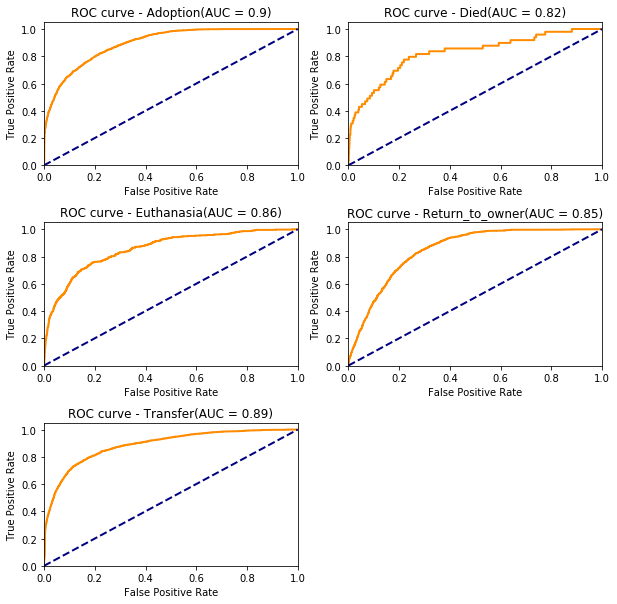

In [425]:
y_test_bin = label_binarize(y_test[:,0], GB.classes_)
plotROCCurves(GB.classes_, labelMapper.features[0][1].inverse_transform(GB.classes_), y_test_bin, proba)

In [426]:
from sklearn.metrics import confusion_matrix
print labelMapper.features[0][1].inverse_transform(GB.classes_)
cm = confusion_matrix(y_test[:,0], preds)#y_train[:,0]
print np.sum(preds==0)
print np.sum(y_test[:,0]==0)
print sum(cm[:,0])
cm


['Adoption' 'Died' 'Euthanasia' 'Return_to_owner' 'Transfer']
3744
3259
3744


array([[2662,    0,    1,  335,  261],
       [   5,    0,    2,    3,   39],
       [  79,    1,    7,   99,  266],
       [ 569,    0,    0,  660,  214],
       [ 429,    0,    3,  242, 2142]])

In [ ]:

from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

clf2 = RandomForestClassifier(n_jobs=4, n_estimators=50, bootstrap=False)


cvobj = StratifiedKFold(n_splits=3, shuffle=True)
#selector = RFECV(svm.SVC(kernel="linear"), cv=3)
selector = RFECV(clf2, cv=cvobj, scoring="f1_weighted")
selector.fit(X_train, np.ravel(y_train))
print selector.support_
print selector.ranking_
print selector.grid_scores_

print max(selector.grid_scores_)
print min(selector.grid_scores_)
print avg(selector.grid_scores_)
#X_train_fitted2 = X_train2#[:,selector.support_]

#scores = cross_val_score(clf2, X_train, y_train, cv=cvobj, scoring="f1_weighted")
#print scores
#print np.average(scores)


In [ ]:
print max(selector.grid_scores_)
print min(selector.grid_scores_)
print np.average(selector.grid_scores_)


Which features did the Recursive Feature Elimination algorithm deem not important?

In [ ]:
prepared_fitted_df.columns[selector.support_]

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

clf2.fit(X_train[:,selector.support_], y_train)
proba = clf2.predict_proba(X_test[:,selector.support_])
preds = clf2.predict(X_test[:,selector.support_])
print preds
print X_test.shape
print y_test.shape
print "f1 score=", f1_score(y_test, preds, average="weighted")
print "log loss=", log_loss(y_test, proba, labels=clf2.classes_)
comp = (preds==y_test)
print proba
print comp
print y_test
print preds
print (float(sum(comp)))/len(comp)



In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, clf2.classes_)
print y_test_bin
print proba
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(clf2.n_classes_):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    

In [ ]:
f, plts = plt.subplots(3, 2, figsize=(10, 10))

plts = plts.ravel()
lw = 2

classlabels=labelMapper.features[0][1].inverse_transform(clf2.classes_)

for cls in range(0, len(plts)):#range(0, clf2.n_classes_):
    #plt.subplot(3,2,cls+1)
    if (cls < clf2.n_classes_):
        plts[cls].plot(fpr[cls], tpr[cls], color='darkorange',
                 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[cls])
        plts[cls].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plts[cls].set_xlim([0.0, 1.0])
        plts[cls].set_ylim([0.0, 1.05])
        plts[cls].set_xlabel('False Positive Rate')
        plts[cls].set_ylabel('True Positive Rate')
        plts[cls].set_title('ROC curve - '+classlabels[cls]+"(AUC = " + str(round(roc_auc[cls], 2))+ ")")
        plt.legend(loc="lower right")
    else:
        plts[cls].axis("off")

f.subplots_adjust(hspace=0.4)
plt.show()

In [ ]:
testdf = pd.read_csv("test.csv")

splitSex(testdf)
cleanupBreed(testdf)
testdf = processBreed(testdf, breedsTDM)    
processAge(testdf)    
processDate(testdf)
processWeekend(testdf)
processName(testdf)
processColor(testdf)
#prepareOutcome(testdf)

prepared_testdf = testdf.copy()
print prepared_testdf.head()
prepared_testdf = prepared_testdf.drop(["ID", "Name", "DateTime", "SexuponOutcome", "AgeuponOutcome", "Breed", "Color"], axis=1)
#prepared_fitted_df = prepared_fitted_df.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor", "OutcomeType" ], axis=1)

print prepared_testdf.head()

prepared_fitted_testdf = mapper.fit_transform(prepared_testdf)

#prepared_fitted_df = prepared_fitted_df.drop(["SimpleColor"], axis=1)
##prepared_fitted_df["Size"] = preprocessing.StandardScaler().fit_transform(prepared_fitted_df[["Size"]])
#prepared_fitted_df["SimpleColor"] = preprocessing.StandardScaler(prepared_fitted_df["SimpleColor"])
print prepared_fitted_testdf.columns
# Drop redundant columns to avoid the Dummy Variable Trap
#if animal=="Dog":
prepared_fitted_testdf = prepared_fitted_testdf.drop(["Sex_unknown",  "AgeBracket_senior", "DaySegment_HR_7", "SimpleColor" ], axis=1)
prepared_fitted_testdf.head()

In [ ]:
#clf2.fit(ss_features[:,selector.support_], ss_classes)

X_kaggle_test = prepared_fitted_testdf.values
print prepared_fitted_testdf.head()
print prepared_fitted_df.head()
preds = clf2.predict(X_kaggle_test[:,selector.support_])
probs = clf2.predict_proba(X_kaggle_test[:,selector.support_])
print clf2.classes_
print labelMapper.features[0][1].inverse_transform(clf2.classes_)
results = np.concatenate((testdf[["ID"]].values, probs), axis=1)
resultsdf = pd.DataFrame(results, columns=["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
resultsdf["ID"] = resultsdf["ID"].astype(int)
resultsdf.to_csv("results3csv", index=False)
resultsdf